In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import style
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib.gridspec import GridSpec
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
# !pip install missingno
import missingno as msn
from sklearn.linear_model import LinearRegression
import joblib
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, f1_score, recall_score, roc_auc_score
from sklearn.feature_selection import SelectKBest,chi2
from sklearn import naive_bayes, svm,metrics
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.linear_model import LogisticRegression
# !pip install imblearn
from imblearn.over_sampling import SMOTE

In [2]:
dataOriginal = pd.read_csv('../Dataset/healthcare-dataset-stroke-data.csv')
dataOriginal.head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


In [3]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(go.Indicator(
                mode = "number",
                value = dataOriginal.shape[0],
                number={'font':{'color': '#7b68ee', 'size':100}},
                delta = {"reference": 600},
                title = {"text": "Rows 🗒 <br><span style="
                                 "'font-size:0.7em;color:gray'>in the data</span>"},
                domain = {'y': [0.7, 1], 'x': [0, 0.5]}))

fig.add_trace(go.Indicator(
                mode = "number",
                value = dataOriginal.shape[1],
                number={'font':{'color': '#7b68ee', 'size':100}},
                delta = {"reference": 600, "valueformat": ".0f"},
                title = {"text": "Columns 🏛 <br><span style="
                                 "'font-size:0.7em;color:gray'>in the data</span>"},
                domain = {'y': [0, 0.3], 'x': [0.5, 1]}))
fig.show()

In [4]:
dataOriginal.describe().T

,count,mean,std,min,25%,50%,75%,max
id,5110.0,36517.829354,21161.721625,67.00,17741.250,36932.000,54682.00,72940.00
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60
stroke,5110.0,0.048728,0.215320,0.00,0.000,0.000,0.00,1.00


Text(0.5, 1.15, 'Missing values')

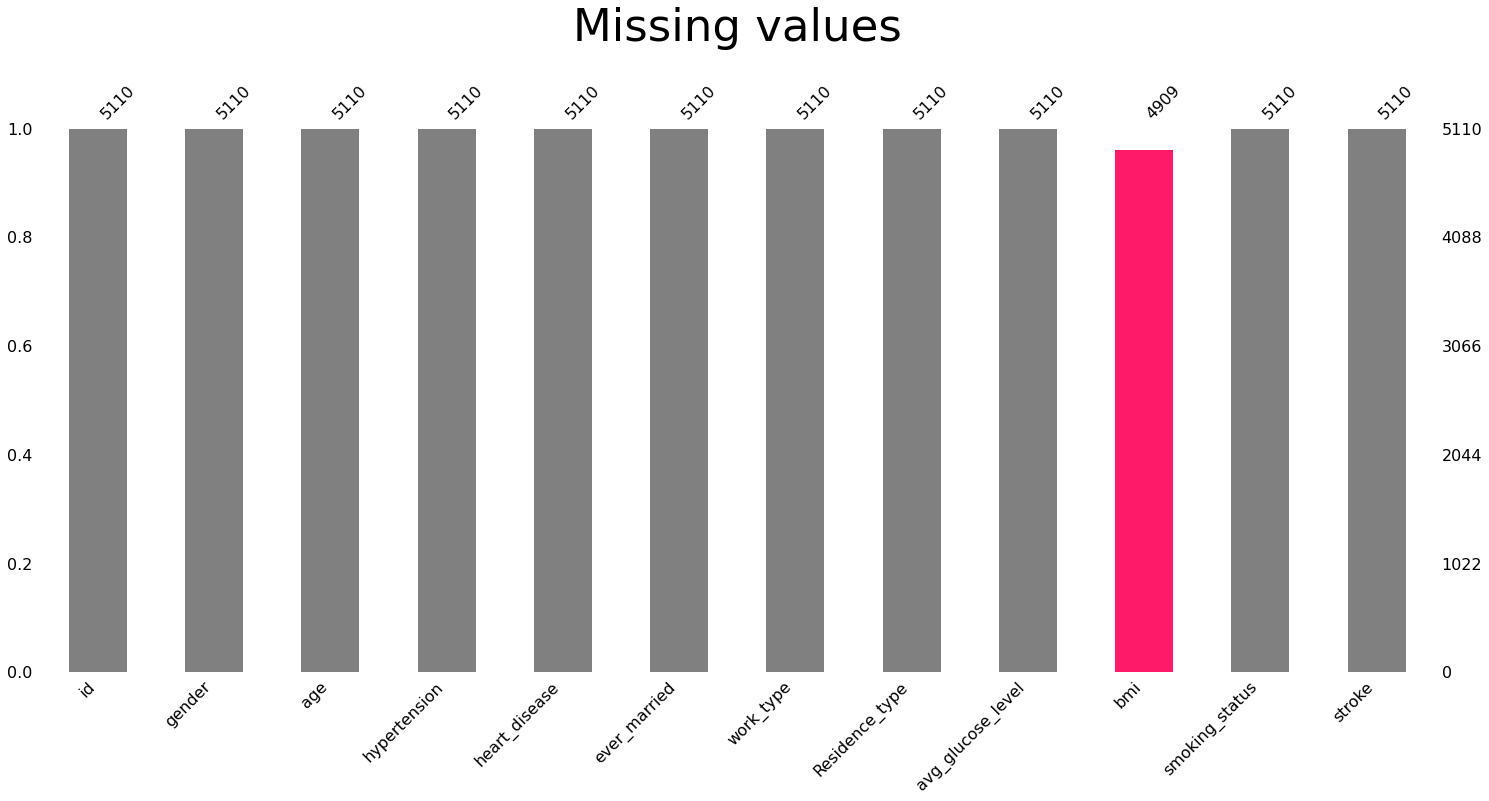

In [5]:
mis_val_colors = []

for col in dataOriginal.columns:
    if dataOriginal[col].isna().sum() != 0:
        mis_val_colors.append('#fe1969')
    else:
        mis_val_colors.append('gray')

msn.bar(dataOriginal, color=mis_val_colors)
plt.title('Missing values', size=45, y=1.15)

Όπως Μπορεί κανείς να δει απο το παραπάνω bar plot ο δείκτης BMI περιέχει κάποιες κενές τιμές ή missing values.
Ας αντικαταστήσουμε τις χαμένες τιμές με τον αριθμιτικό μέσο του δείκτη αυτού. Σαν δεύτερο πείραμα θα αντικαταστήσουμε αυτές τις NaN values με την βοηθεία μιας Linear Regression, με features με το μεγαλύτερο correlation value απο τον correlation matrix.

In [6]:


lr = LinearRegression()
datanew = dataOriginal[['age', 'ever_married', 'smoking_status','avg_glucose_level','bmi']].copy()

traindf = datanew[datanew['bmi'].isnull()==False]
testdf = datanew[datanew['bmi'].isnull()==True]
y = traindf['bmi']
traindf.drop("bmi",axis=1,inplace=True)
cat_columns = [cname for cname in traindf.columns
                            if traindf[cname].dtype == 'object']

encoder = preprocessing.LabelEncoder()

for col in cat_columns:
    traindf[col] = encoder.fit_transform(traindf[col])

cat_columns = [cname for cname in testdf.columns
                            if testdf[cname].dtype == 'object']

encoder = preprocessing.LabelEncoder()

for col in cat_columns:
    testdf[col] = encoder.fit_transform(testdf[col])    
lr.fit(traindf,y)
testdf.drop("bmi",axis=1,inplace=True)
pred = lr.predict(testdf)
testdf['bmi']= pred


C:\Users\ppetropo\AppData\Roaming\Python\Python39\site-packages\pandas\core\frame.py:4305: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ppetropo\AppData\Local\Temp/ipykernel_12624/28497871.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ppetropo\AppData\Local\Temp/ipykernel_12624/28497871.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

## Fill NaN values with mean value of the bmi

In [7]:
def FillWithMean(dataOriginal):
    data = dataOriginal


    data['bmi'] = data['bmi'].fillna(np.round(data.bmi.mean(), 2))
    mis_val_colors_after = []

    for col in data.columns:
        if data[col].isna().sum() != 0:
            mis_val_colors_after.append('#fe1969')
        else:
            mis_val_colors_after.append('limegreen')

    msn.bar(data, color=mis_val_colors_after)
    plt.title('Missing values', size=45, y=1.15)
    return data

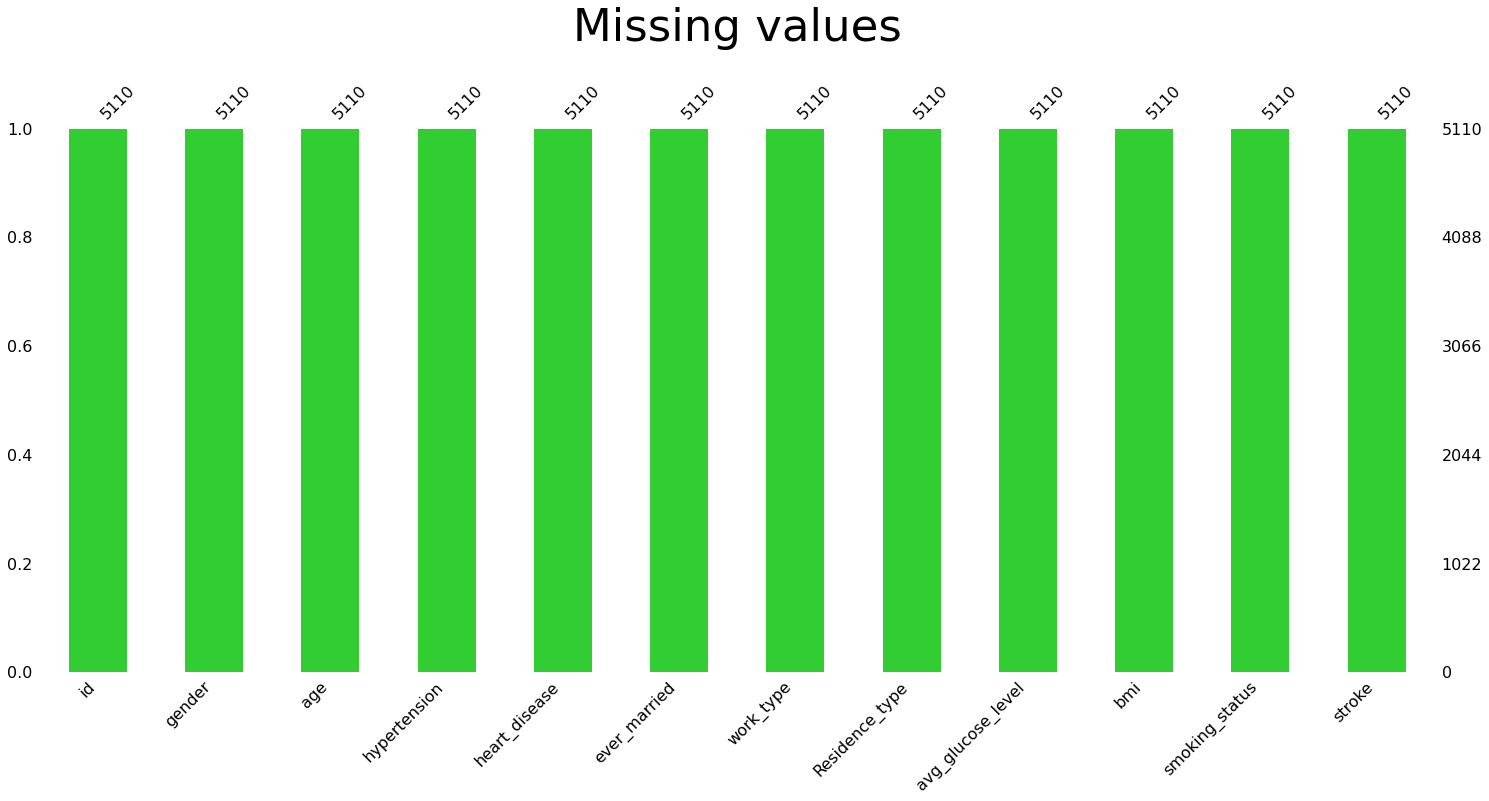

In [8]:
data = FillWithMean(dataOriginal)

## Fill NaN values with Multivariate Linear Regression

In [9]:
def FillWithLR(dataOriginal):
    data = dataOriginal
    # data[data['bmi'].isnull==True] = testdf['bmi']
    data['bmi'] = data['bmi'].fillna(testdf['bmi'])

    # data['bmi'] = data['bmi'].fillna(np.round(data.bmi.mean(), 2))
    mis_val_colors_after = []

    for col in data.columns:
        if data[col].isna().sum() != 0:
            mis_val_colors_after.append('#fe1969')
        else:
            mis_val_colors_after.append('limegreen')

    msn.bar(data, color=mis_val_colors_after)
    plt.title('Missing values', size=45, y=1.15)
    return data

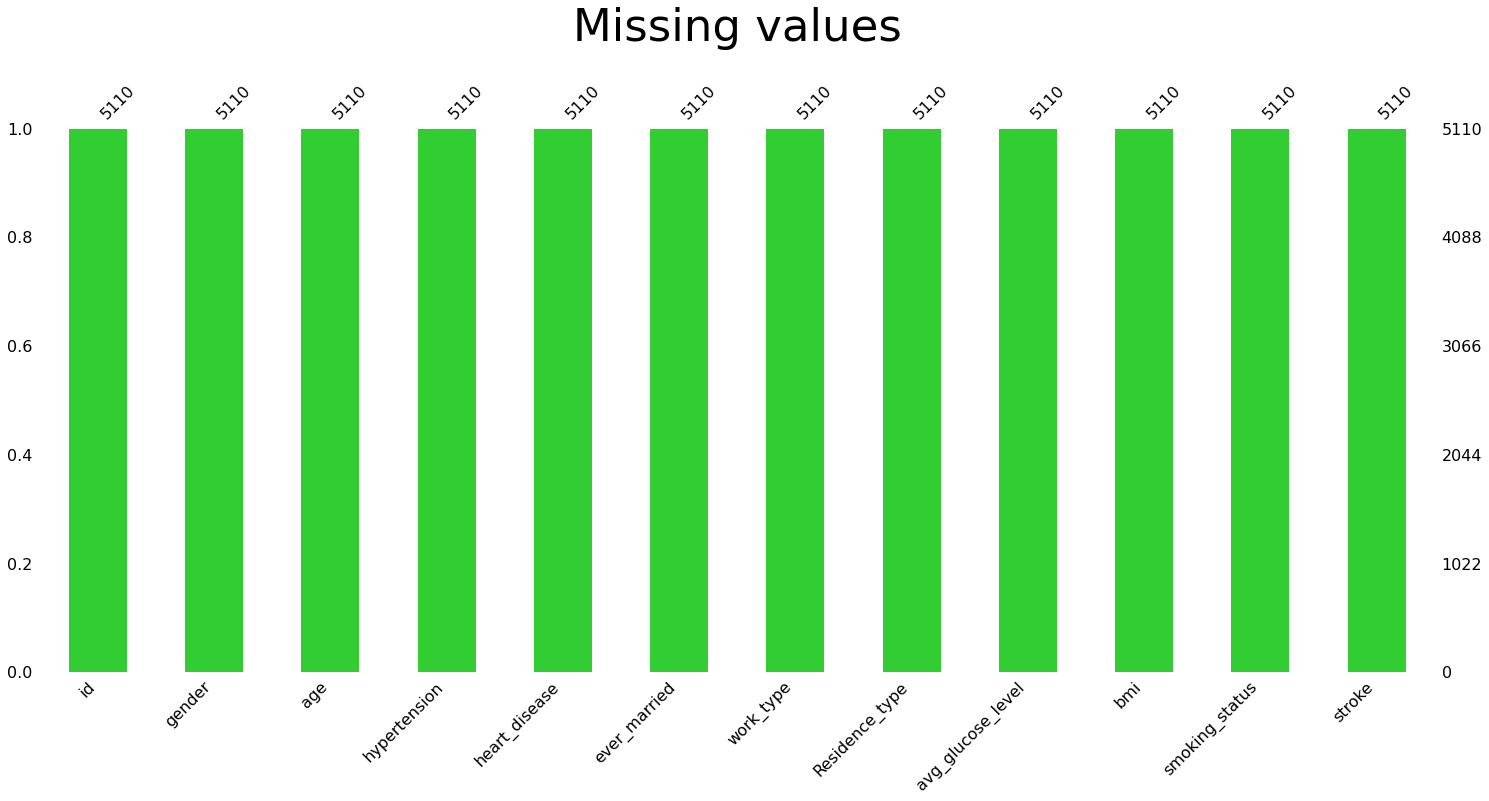

In [10]:
data2 = FillWithLR(dataOriginal)

0    4861
1     249
Name: stroke, dtype: int64


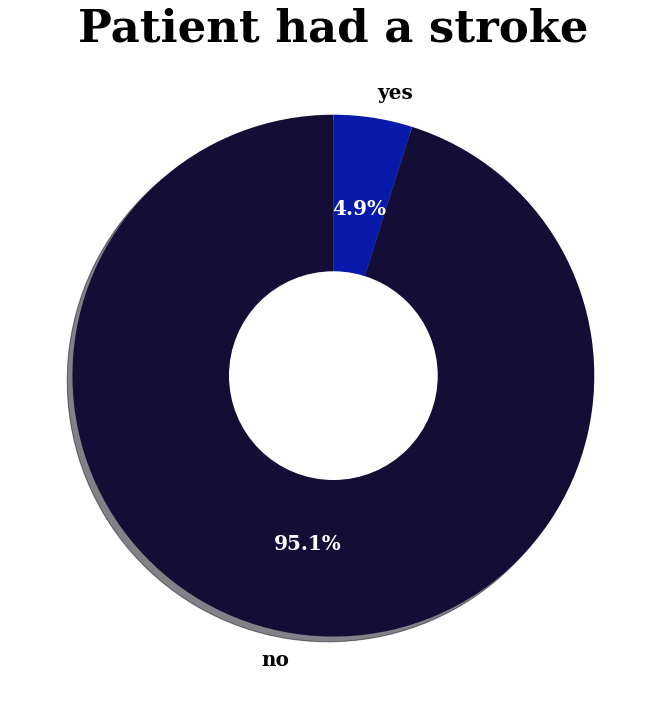

In [11]:
pie_colors = ('#140E36', '#091AAB')

pred_classes = data.stroke.value_counts()
print(pred_classes)

plt.figure(figsize=(17, 12))
patches, texts, pcts = plt.pie(pred_classes,
                               labels=['no', 'yes'],
                               colors=pie_colors,
                               pctdistance=0.65,
                               shadow=True,
                               startangle=90,
                               autopct='%1.1f%%',
                               textprops={'fontsize': 20,
                                          'color': 'black',
                                          'weight': 'bold',
                                          'family': 'serif'})
plt.setp(pcts, color='white')

hfont = {'fontname':'serif', 'weight': 'bold'}
plt.title('Patient had a stroke', size=45, **hfont)

centre_circle = plt.Circle((0,0),0.40,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
data.drop(['id'], axis=1, inplace=True)

[Text(0, 0, 'Male'), Text(0, 1, 'Female')]

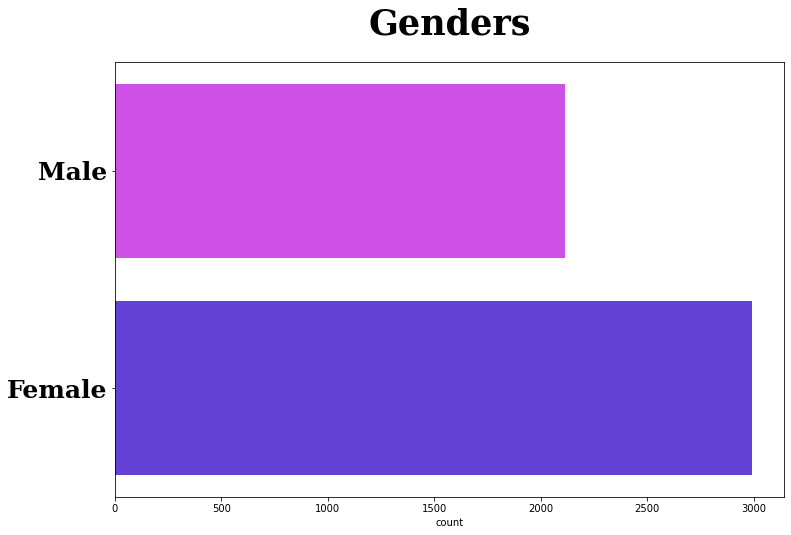

In [12]:
data = data[data.gender != 'Other']
plt.figure(figsize=(12, 8))
gender_plot = sns.countplot(y=data.gender, palette=['#dd38ff', '#5727ed'])
gender_plot.set_title('Genders', fontsize=35, y=1.05, **hfont)
gender_plot.set(ylabel=None)
plt.grid(False)
gender_plot.set_yticklabels(gender_plot.get_yticklabels(), size=25, **hfont)

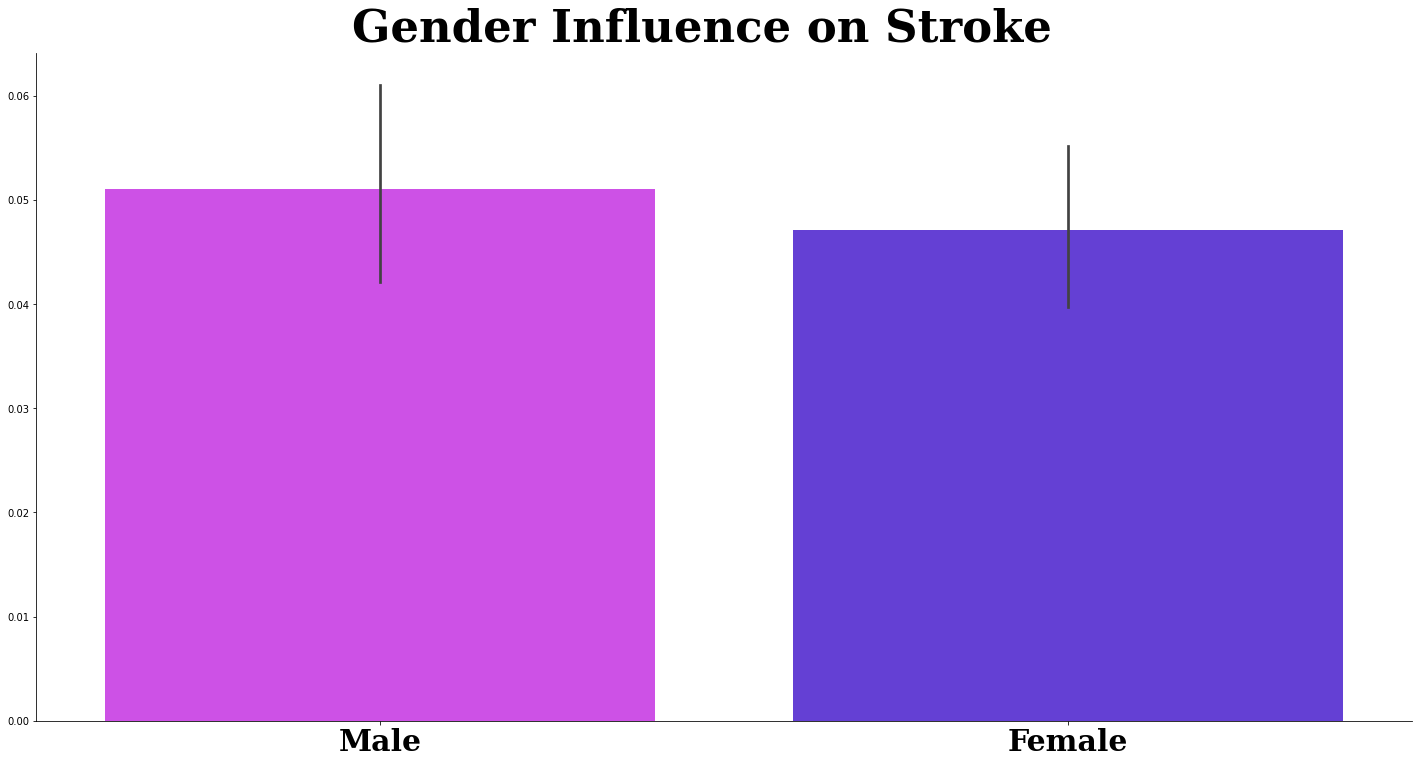

In [13]:
gender_plot = sns.catplot(x='gender', y='stroke', data=data,
                             height=10, aspect=2, kind='bar',
                             palette=['#dd38ff', '#5727ed'])
gender_plot.set_xticklabels(['Male', 'Female'], size=30, **hfont)
gender_plot.fig.suptitle('Gender Influence on Stroke',
                            size=45, y=1.05, **hfont)
gender_plot.set(xlabel=None, ylabel=None)

Text(0.5, 0, 'Age')

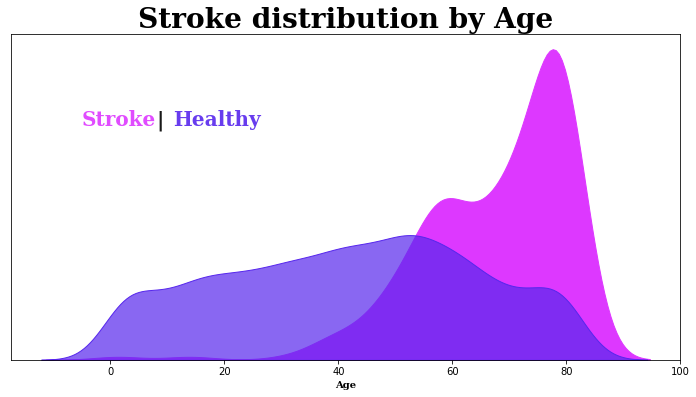

In [14]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
plt.title('Stroke distribution by Age', size=28, **hfont)
ax.grid(False)
ax.axes.get_yaxis().set_visible(False)
ax.text(-5, 0.03, 'Stroke', {'font': 'Serif',
                             'size': '20',
                             'weight': 'bold',
                             'color': '#dd38ff'}, alpha=0.9)

ax.text(8, 0.03, '|', {'font': 'Serif',
                       'size': '20',
                       'weight': 'bold',
                       'color': 'black'}, alpha=0.9)

ax.text(11, 0.03, 'Healthy', {'font': 'Serif',
                              'size': '20',
                              'weight': 'bold',
                              'color': '#5727ed'}, alpha=0.9)

sns.kdeplot(data=data[data.stroke == 1],
            x='age', shade=True, ax=ax, color='#dd38ff', alpha=1)
sns.kdeplot(data=data[data.stroke == 0],
            x='age', shade=True, ax=ax, color='#5727ed', alpha=0.7)
plt.xlabel('Age', **hfont)

Απο την παραπάνω κατανομή, μπορεί κανείς να καταλάβει οτι μεγαλύτερη πιθανότητα Εγκεφαλικού έχουν οι ηλικιακές ομάδες μεταξύ 70 και 80 χρονών.

C:\Users\ppetropo\AppData\Local\Temp/ipykernel_17776/2895794523.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



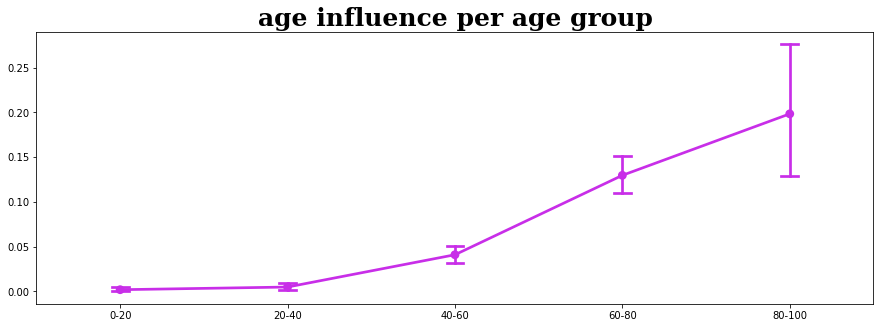

In [15]:
def age_plot(data, col_name):

    age_data = data[[col_name, 'stroke']]
    age_data[col_name] = pd.cut(age_data[col_name],
                               bins=[0, 20, 40, 60, 80, 100],
                               labels=['0-20',
                                       '20-40',
                                       '40-60',
                                       '60-80',
                                       '80-100'])

    color = np.random.choice(['#3E1CA8', '#5727ed', '#C82EE8', '#dd38ff', '#EC96FE'], 1)[0]
    plt.figure(figsize=(15, 5))
    plot = sns.pointplot(x=col_name, y='stroke',
                  dodge=0.1, capsize=.1, data=age_data, color=color)
    plot.set_title(f'{col_name} influence per age group', fontsize=25, **hfont)
    plot.set(xlabel=None, ylabel=None)


age_plot(data, 'age')

Από το παραπάνω plot μπορεί κανείς να παρατηρήσει οτι όσο πιο μεγάλο ηλικιακά είναι ένα άτομο, τόσο πιο πιθανό είναι να πάθει εγκεφαλικό. Η ηλικία δηλαδή παίζει αρκετά μεγάλο ρόλο.

[Text(0, 0, 'No'), Text(1, 0, 'Yes')]

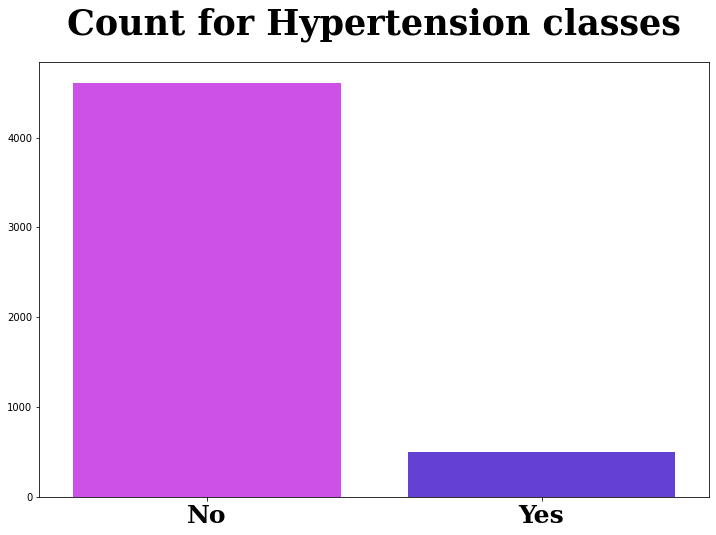

In [16]:
plt.figure(figsize=(12, 8))
hypertension_plot = sns.countplot(x=data.hypertension,
                            palette=['#dd38ff', '#5727ed'])
hypertension_plot.set_title('Count for Hypertension classes',
                      fontsize=35, y=1.05, **hfont)
hypertension_plot.set(xlabel=None, ylabel=None)
plt.grid(False)
hypertension_plot.set_xticklabels(['No', 'Yes'], size=25, **hfont)

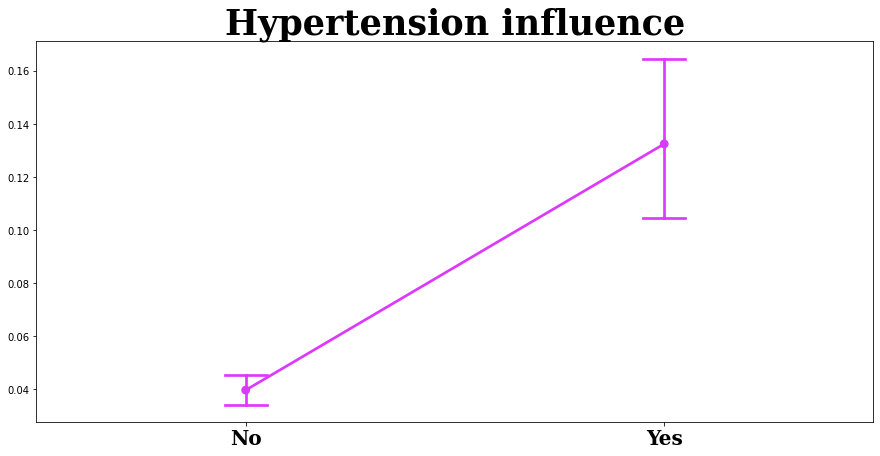

In [17]:
def hypertension_plot(data, col_name):

    hypertension_data = data[[col_name, 'stroke']]

    color = np.random.choice(['#3E1CA8', '#5727ed', '#C82EE8', '#dd38ff', '#EC96FE'], 1)[0]
    plt.figure(figsize=(15, 7))
    hypertension = sns.pointplot(x=col_name, y='stroke',
                           dodge=0.5, capsize=.1,
                           data=hypertension_data,
                           color=color)
    hypertension.set_title('Hypertension influence',
                            fontsize=35, **hfont)
    hypertension.set(xlabel=None, ylabel=None)
    hypertension.set_xticklabels(['No', 'Yes'], size=20, **hfont)


hypertension_plot(data, 'hypertension')

Το παραπάνω Plot μας δείχνει οτι όποιος έχει υπέραταση έχει και πιο πολλές πιθανότητες να πάθει εγκεφαλικό επισόδειο. Δηλάδη η υπέρταση επηρεάζει αρκετά τον ρίσκο εγκεφαλικού.

Text(0.5, 1.0, 'Heart Disease')

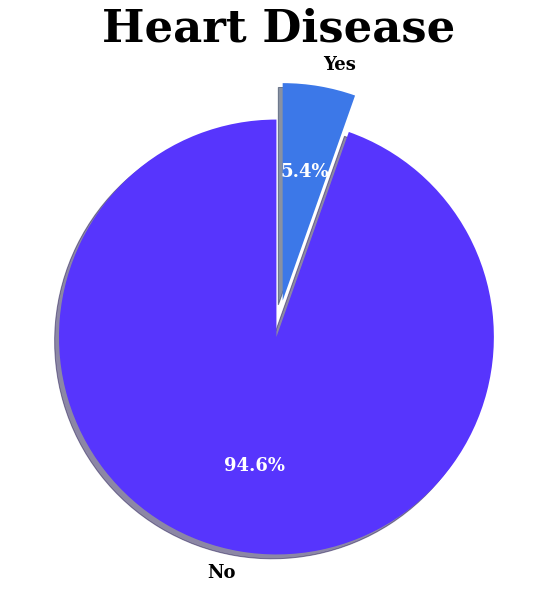

In [18]:
heart_dis_data = data.heart_disease.value_counts()

explode = (0.07, 0.1)
pie_colors = ('#5735FD', '#3C78E8')

plt.figure(figsize=(15, 10))
patches, texts, pcts = plt.pie(heart_dis_data,
                               labels=['No', 'Yes'],
                               explode=explode,
                               colors=pie_colors,
                               shadow=True,
                               startangle=90,
                               autopct='%1.1f%%',
                               textprops={'fontsize': 18,
                                          'color': 'black',
                                          'weight': 'bold',
                                          'family': 'serif'})
plt.setp(pcts, color='white')
plt.title('Heart Disease', size=45, **hfont)

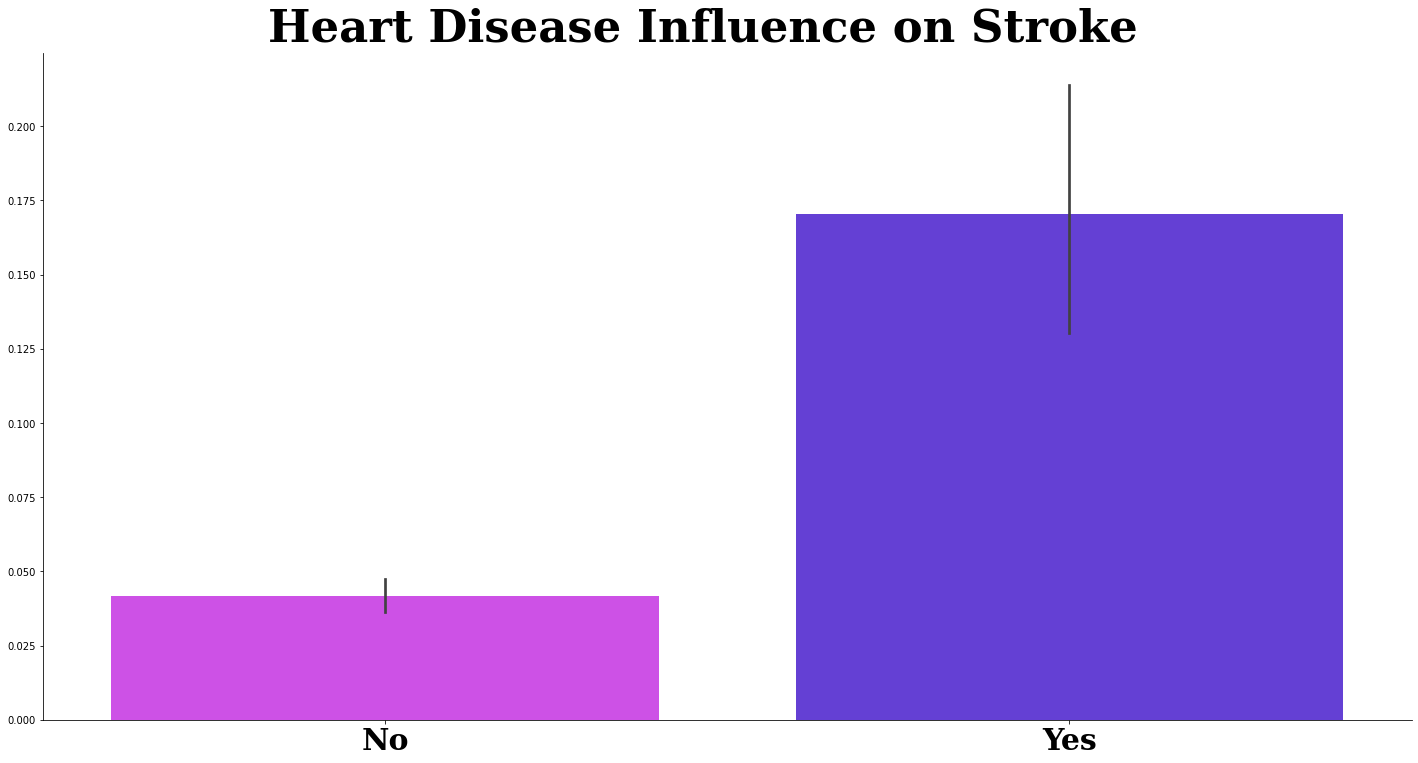

In [19]:
heart_dis_plot = sns.catplot(x='heart_disease', y='stroke', data=data,
                             height=10, aspect=2, kind='bar',
                             palette=['#dd38ff', '#5727ed'])
heart_dis_plot.set_xticklabels(['No', 'Yes'], size=30, **hfont)
heart_dis_plot.fig.suptitle('Heart Disease Influence on Stroke',
                            size=45, y=1.05, **hfont)
heart_dis_plot.set(xlabel=None, ylabel=None)

Είναι λογικό κάποια καρδιακή ασθένεια να επιρεάζει και την πιθανότητα εγκεφαλικου. Είναι κάτι το οποίο επιβεβαιώνεται και απο το παραπάνω plot. 

Text(0.5, 1.0, 'Married (y/n)')

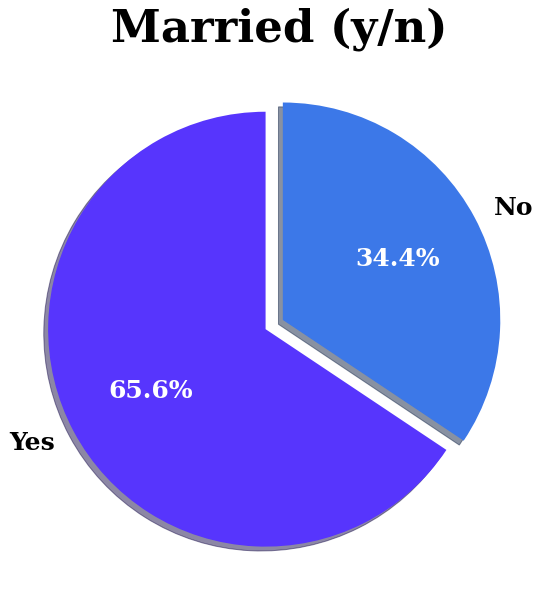

In [20]:
married_data = data.ever_married.value_counts()

explode = (0.07, 0.02)
pie_colors = ('#5735FD', '#3C78E8')

plt.figure(figsize=(15, 10))
patches, texts, pcts = plt.pie(married_data,
                               labels=married_data.index,
                               explode=explode,
                               colors=pie_colors,
                               shadow=True,
                               startangle=90,
                               autopct='%1.1f%%',
                               textprops={'fontsize': 25,
                                          'color': 'black',
                                          'weight': 'bold',
                                          'family': 'serif'})
plt.setp(pcts, color='white')
plt.title('Married (y/n)', size=45, **hfont)

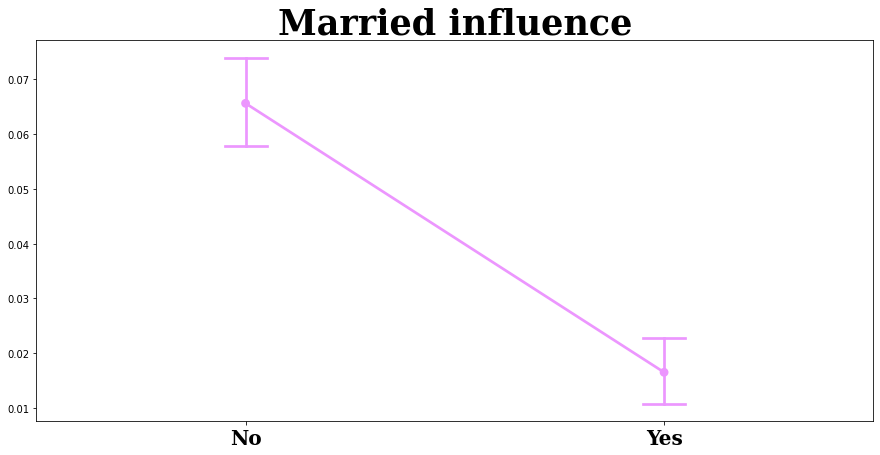

In [21]:
def married_plot(data, col_name):

    married_data = data[[col_name, 'stroke']]

    color = np.random.choice(['#3E1CA8', '#5727ed', '#C82EE8', '#dd38ff', '#EC96FE'], 1)[0]
    plt.figure(figsize=(15, 7))
    married = sns.pointplot(x=col_name, y='stroke',
                            dodge=0.1, capsize=.1,
                            data=married_data,
                            color=color)
    married.set_title('Married influence', fontsize=35, **hfont)
    married.set(xlabel=None, ylabel=None)
    married.set_xticklabels(['No', 'Yes'], size=20, **hfont)


married_plot(data, 'ever_married')

[Text(0, 0, ''),
 Text(1, 0, ''),
 Text(2, 0, ''),
 Text(3, 0, ''),
 Text(4, 0, '')]

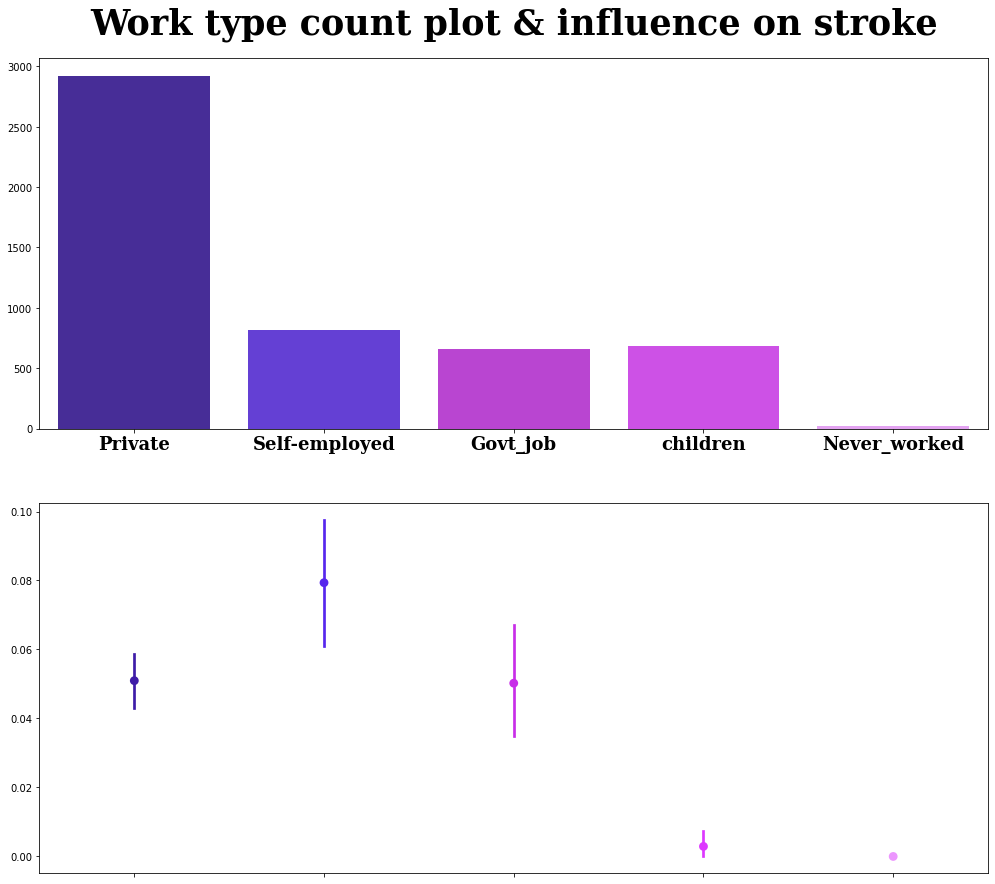

In [22]:
fig = plt.figure(figsize=(17, 15))
grid = GridSpec(ncols=1, nrows=2, figure=fig)

ax1 = fig.add_subplot(grid[0, :])
work_type_plot = sns.countplot(x=data.work_type, ax=ax1, palette=['#3E1CA8', '#5727ed', '#C82EE8', '#dd38ff', '#EC96FE'])
work_type_plot.set_title('Work type count plot &'
                         ' influence on stroke',
                         fontsize=35, y=1.05, **hfont)
work_type_plot.set(xlabel=None,
                   ylabel=None)
work_type_plot.set_xticklabels(work_type_plot.get_xticklabels(),
                                size=18, **hfont)


ax2 = fig.add_subplot(grid[1, :])
work_type_cat = sns.pointplot(x=data.work_type, y='stroke', data=data,
             ax=ax2, palette=['#3E1CA8', '#5727ed', '#C82EE8', '#dd38ff', '#EC96FE'])
work_type_cat.set(xlabel=None,
                   ylabel=None)
work_type_cat.set_xticklabels([])

Θα μπορούσε κανείς να συμπαιράνει οτι τα παιδιά και αυτοί που δεν έχουν ποτέ δουλέψει το risk για stroke προσεγγίζει το μηδέν. 

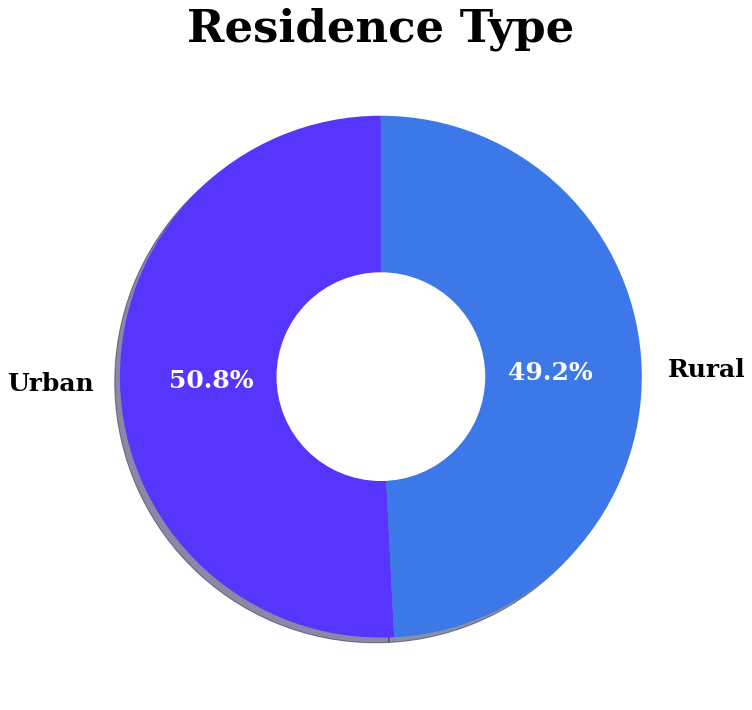

In [23]:
residence_data = data.Residence_type.value_counts()

explode = (0.1, 0.1)
plt.figure(figsize=(17, 12))
patches, texts, pcts = plt.pie(residence_data,
                               labels=residence_data.index,
                               colors=pie_colors,
                               pctdistance=0.65,
                               shadow=True,
                               startangle=90,
                               autopct='%1.1f%%',
                               textprops={'fontsize': 25,
                                           'color': 'black',
                                           'weight': 'bold',
                                           'family': 'serif'})
plt.setp(pcts, color='white')

hfont = {'fontname':'serif', 'weight': 'bold'}
plt.title('Residence Type', size=45, **hfont)

centre_circle = plt.Circle((0,0),0.40,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

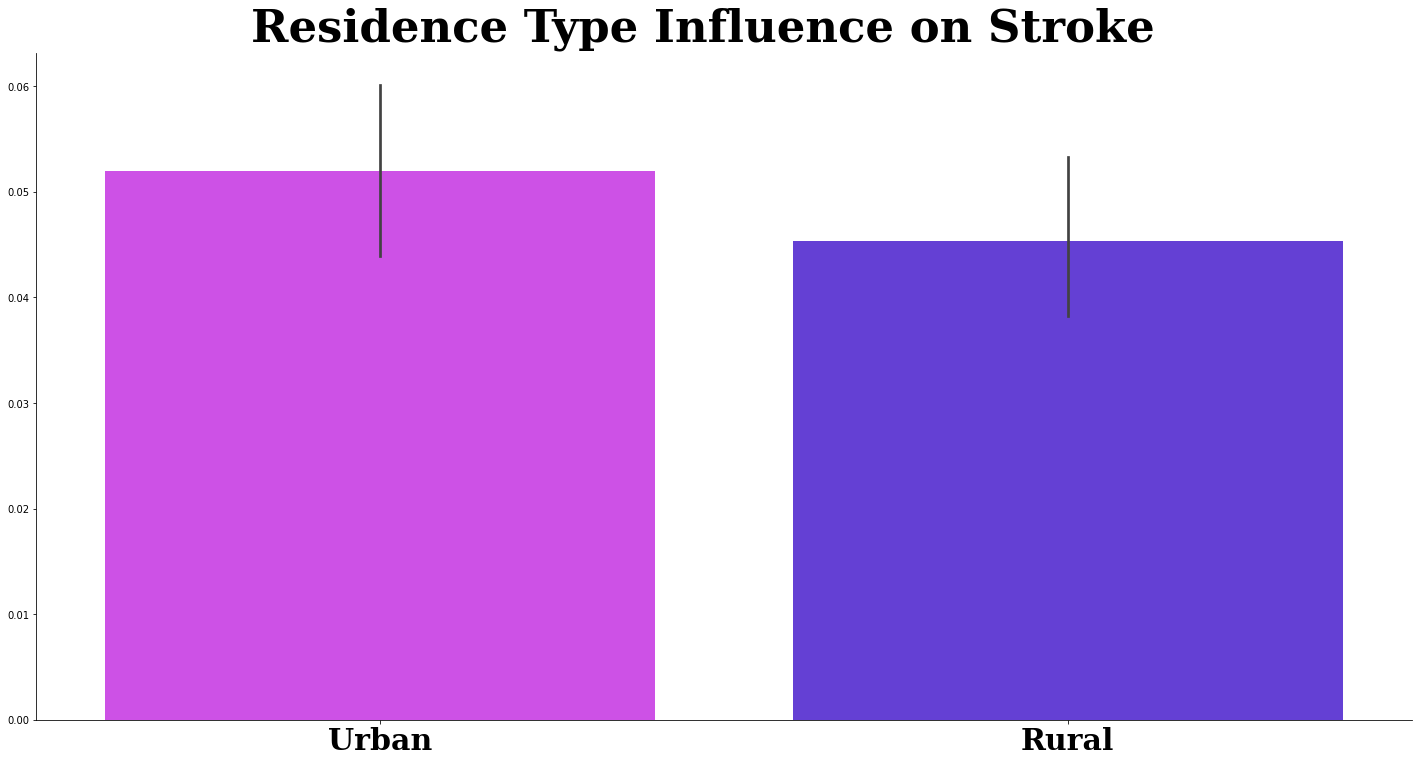

In [24]:
residence_plot = sns.catplot(x='Residence_type', y='stroke', data=data,
                             height=10, aspect=2, kind='bar',
                             palette=['#dd38ff', '#5727ed'])
residence_plot.set_xticklabels(['Urban', 'Rural'],
                               size=30, **hfont)
residence_plot.fig.suptitle('Residence Type Influence on Stroke',
                            size=45, y=1.05, **hfont)
residence_plot.set(xlabel=None, ylabel=None)

Κάποιος που ζεί σε μια πόλη φαίνεται να έχει περισσότερες πιθανότητες για stroke. Μπορεί λόγω άγχους.

Text(0.5, 0, 'AVG glucose lvl')

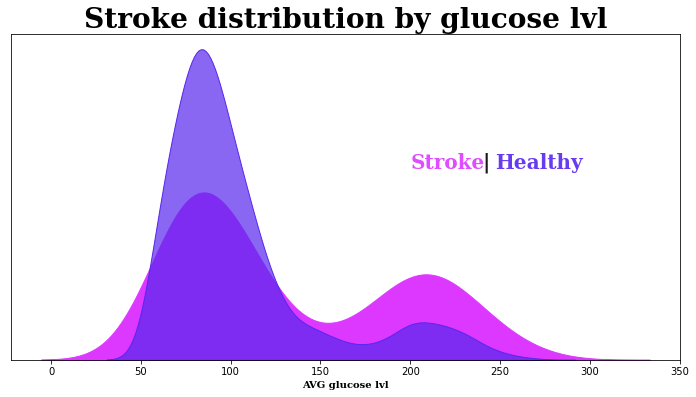

In [25]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
plt.title('Stroke distribution by glucose lvl', size=28, **hfont)
ax.grid(False)
ax.axes.get_yaxis().set_visible(False)
ax.text(200, 0.01, 'Stroke', {'font': 'Serif',
                              'size': '20',
                              'weight': 'bold',
                              'color': '#dd38ff'}, alpha=0.9)

ax.text(240, 0.01, '|', {'font': 'Serif',
                         'size': '20',
                         'weight': 'bold',
                         'color': 'black'}, alpha=0.9)

ax.text(247, 0.01, 'Healthy', {'font': 'Serif',
                               'size': '20',
                               'weight': 'bold',
                               'color': '#5727ed'}, alpha=0.9)

sns.kdeplot(data=data[data.stroke == 1],
            x='avg_glucose_level', shade=True, ax=ax, color='#dd38ff',
            alpha=1)
sns.kdeplot(data=data[data.stroke == 0],
            x='avg_glucose_level', shade=True, ax=ax, color='#5727ed',
            alpha=0.7)
plt.xlabel('AVG glucose lvl', **hfont)

C:\Users\ppetropo\AppData\Local\Temp/ipykernel_17776/1636714420.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



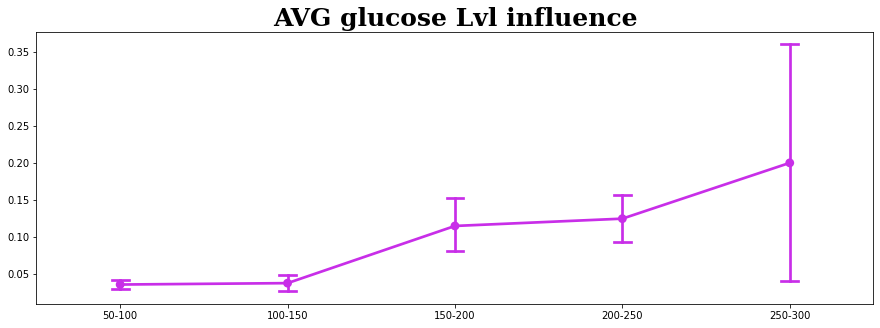

In [26]:
def avg_glucose_plot(data, col_name):

    avg_glucose_data = data[[col_name, 'stroke']]
    avg_glucose_data[col_name] = pd.cut(avg_glucose_data[col_name],
                               bins=[50, 100, 150, 200, 250, 300],
                               labels=['50-100',
                                       '100-150',
                                       '150-200',
                                       '200-250',
                                       '250-300'])

    color = np.random.choice(['#3E1CA8', '#5727ed', '#C82EE8', '#dd38ff', '#EC96FE'], 1)[0]
    plt.figure(figsize=(15, 5))
    plot = sns.pointplot(x=col_name, y='stroke',
                  dodge=0.1, capsize=.1, data=avg_glucose_data, color=color)
    plot.set_title(f'AVG glucose Lvl influence', fontsize=25, **hfont)
    plot.set(xlabel=None, ylabel=None)


avg_glucose_plot(data, 'avg_glucose_level')

Το παραπάνω Plot μας δείχνει οτι όσο πιο υψηλή είναι η τιμή της γλυκόζης στο αίμα, τόσο πιο μεγάλη η πιθανότητα εγκεφαλικου.

Text(0.5, 0, 'BMI')

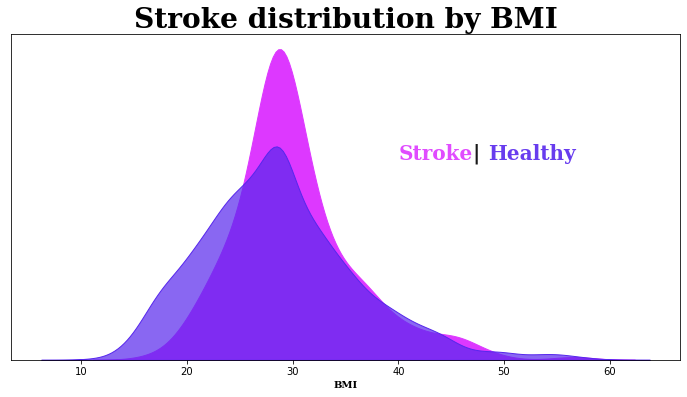

In [27]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
plt.title('Stroke distribution by BMI', size=28, **hfont)
ax.grid(False)
ax.axes.get_yaxis().set_visible(False)
ax.text(40, 0.06, 'Stroke', {'font': 'Serif',
                             'size': '20',
                             'weight': 'bold',
                             'color': '#dd38ff'}, alpha=0.9)

ax.text(47, 0.06, '|', {'font': 'Serif',
                        'size': '20',
                        'weight': 'bold',
                        'color': 'black'}, alpha=0.9)

ax.text(48.5, 0.06, 'Healthy', {'font': 'Serif',
                                'size': '20',
                                'weight': 'bold',
                                'color': '#5727ed'}, alpha=0.9)

sns.kdeplot(data=data[(data.stroke == 1) & (data.bmi < 60)],
            x='bmi', shade=True, ax=ax, color='#dd38ff',
            alpha=1)
sns.kdeplot(data=data[(data.stroke == 0) & (data.bmi < 60)],
            x='bmi', shade=True, ax=ax, color='#5727ed',
            alpha=0.7)
plt.xlabel('BMI', **hfont)

C:\Users\ppetropo\AppData\Local\Temp/ipykernel_17776/513898866.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



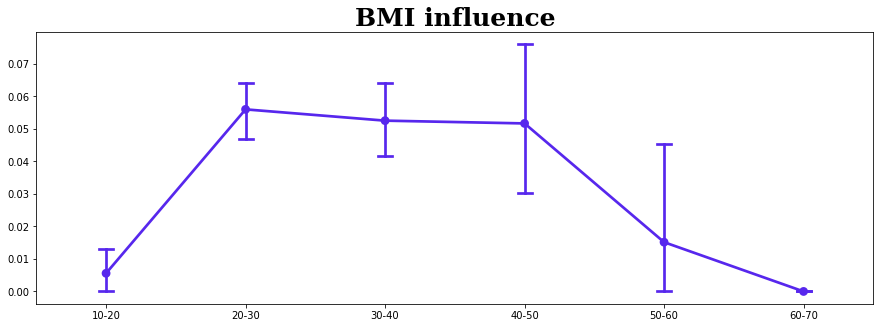

In [28]:
def bmi_plot(data, col_name):

    bmi_data = data[[col_name, 'stroke']]
    bmi_data[col_name] = pd.cut(bmi_data[col_name],
                               bins=[10, 20, 30, 40, 50, 60, 70],
                               labels=['10-20',
                                       '20-30',
                                       '30-40',
                                       '40-50',
                                       '50-60',
                                       '60-70'])

    color = np.random.choice(['#3E1CA8', '#5727ed', '#C82EE8', '#dd38ff', '#EC96FE'], 1)[0]
    plt.figure(figsize=(15, 5))
    plot = sns.pointplot(x=col_name, y='stroke',
                  dodge=0.1, capsize=.1, data=bmi_data, color=color)
    plot.set_title(f'BMI influence', fontsize=25, **hfont)
    plot.set(xlabel=None, ylabel=None)


bmi_plot(data, 'bmi')

[Text(0, 0, ''), Text(1, 0, ''), Text(2, 0, ''), Text(3, 0, '')]

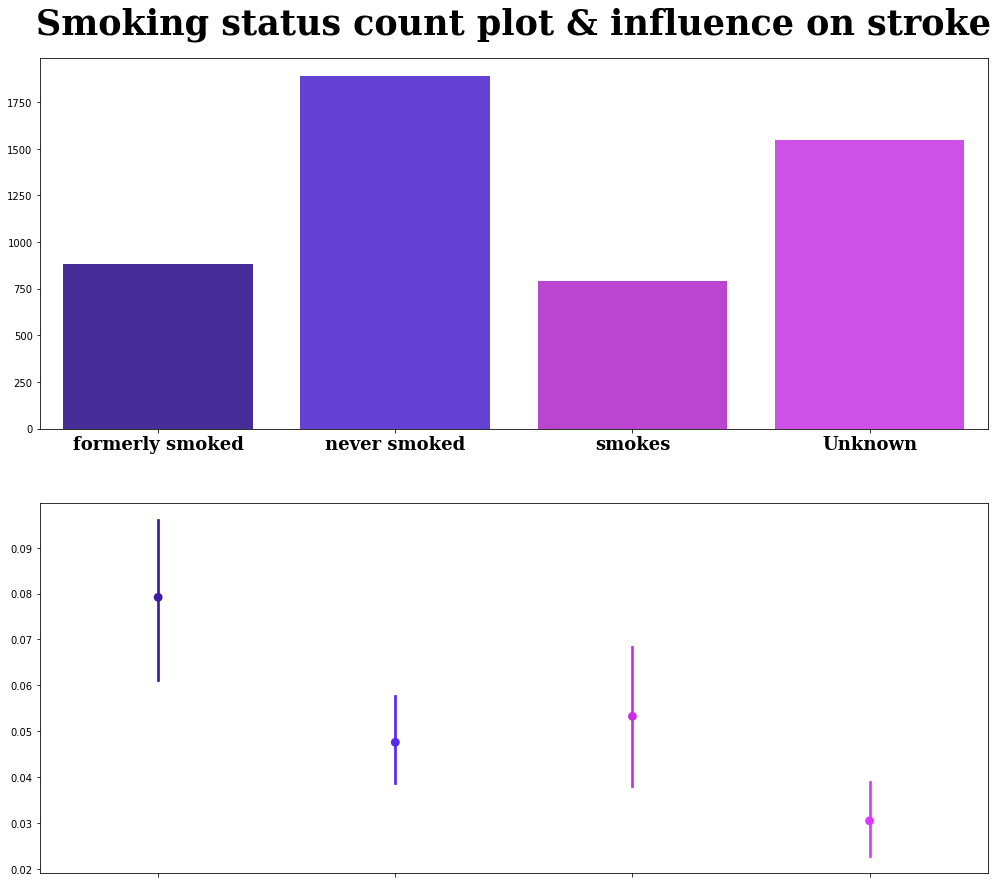

In [29]:
fig = plt.figure(figsize=(17, 15))
grid = GridSpec(ncols=1, nrows=2, figure=fig)

ax1 = fig.add_subplot(grid[0, :])
smoke_plot = sns.countplot(x=data.smoking_status, ax=ax1, palette=['#3E1CA8', '#5727ed', '#C82EE8', '#dd38ff', '#EC96FE'])
smoke_plot.set_title('Smoking status count plot &'
                         ' influence on stroke',
                         fontsize=35, y=1.05, **hfont)
smoke_plot.set(xlabel=None,
                   ylabel=None)
smoke_plot.set_xticklabels(smoke_plot.get_xticklabels(),
                                size=18, **hfont)


ax2 = fig.add_subplot(grid[1, :])
smoke_cat = sns.pointplot(x=data.smoking_status, y='stroke', data=data,
             ax=ax2, palette=['#3E1CA8', '#5727ed', '#C82EE8', '#dd38ff', '#EC96FE'])
smoke_cat.set(xlabel=None,
                   ylabel=None)
smoke_cat.set_xticklabels([])

In [12]:
data['gender']=data['gender'].apply(lambda x: 1 if x=='Male' else 0)
data['ever_married']=data['ever_married'].apply(lambda x: 1 if x=='Yes' else 0)
data['Residence_type']=data['Residence_type'].apply(lambda x: 1 if x=='Urban' else 0)


def func1(x):
    if x=='Private':
        return 0
    elif x=='Self-employed':
        return 1
    elif x=='Govt-job':
        return 2
    elif x=='children':
        return 3
    else:
        return 4

def func2(x):
    if x=='formerly smoked':
        return 0
    elif x=='never smoked':
        return 1
    elif x=='smokes':
        return 2
    else:
        return 3

data['work_type']=data['work_type'].apply(func1)

data['smoking_status']=data['smoking_status'].apply(func2)


In [31]:

cat_columns = [cname for cname in data.columns
                        if data[cname].dtype == 'object']

# encoder = preprocessing.LabelEncoder()

# for col in cat_columns:
#     data[col] = encoder.fit_transform(data[col])


strokeDF = data[data['stroke']==1]
nostrokeDF = data[data['stroke']==0]
valuesStroke= strokeDF.drop(['stroke'], axis=1).values.flatten().tolist()
valuesNoStroke=nostrokeDF.drop(['stroke'], axis=1).values.flatten().tolist()

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=valuesStroke,
      theta=['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status'],
      fill='toself',
      name='Stroke'
))
fig.add_trace(go.Scatterpolar(
      r=valuesNoStroke,
      theta=['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status'],
      fill='toself',
      name='No-Stroke'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 2]
    )),
  showlegend=True
)

fig.show()

<AxesSubplot:>

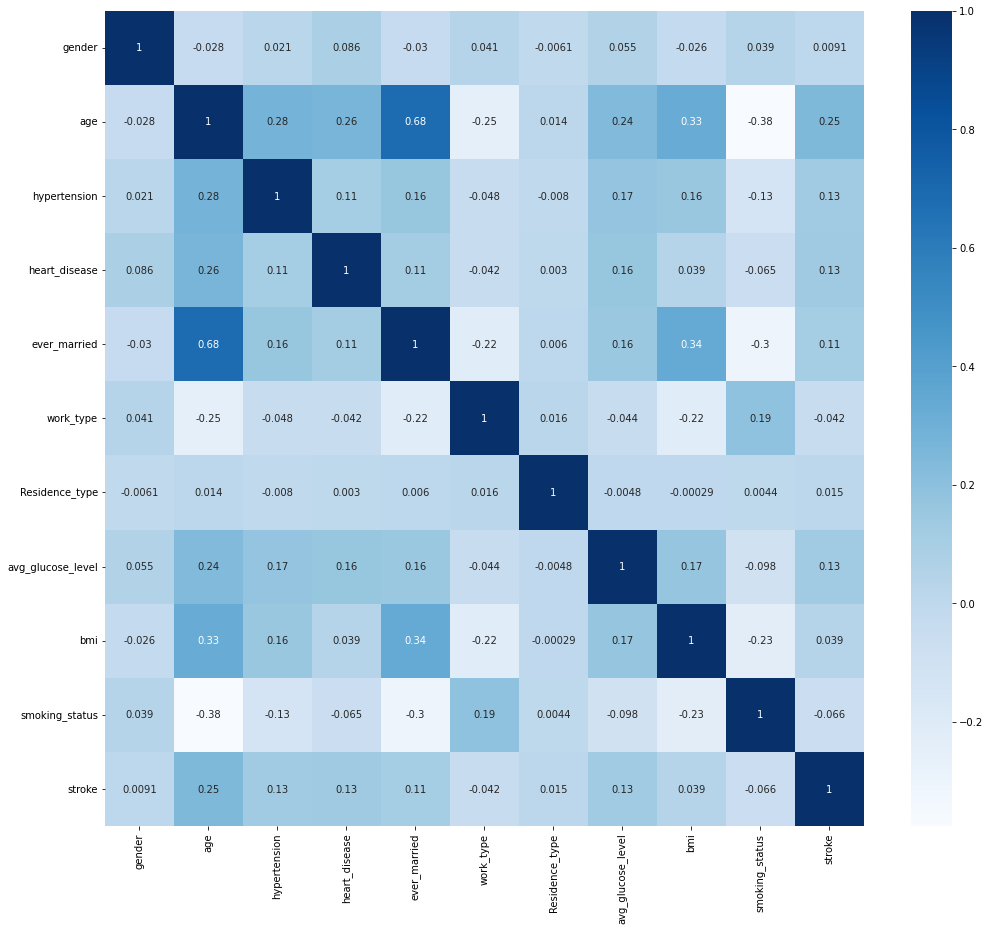

In [32]:
plt.figure(figsize=(17, 15))

corr_mask = np.triu(data.corr())
h_map = sns.heatmap(data.corr(),  annot= True, cmap='Blues')
h_map

Απο τον παραπάνω correlation matrix μπορεί κανείς να δει οτι τα features που έχουν την μεγαλύτερη συσχέτηση είναι:
 1. age
 2. ever_married
 3. smoking_status
 4. avg_glucose_level
 5. bmi
 6. hypertension
 7. Heart_disease

# Fill nan values with mean of BMI

## Metrics with chi2 

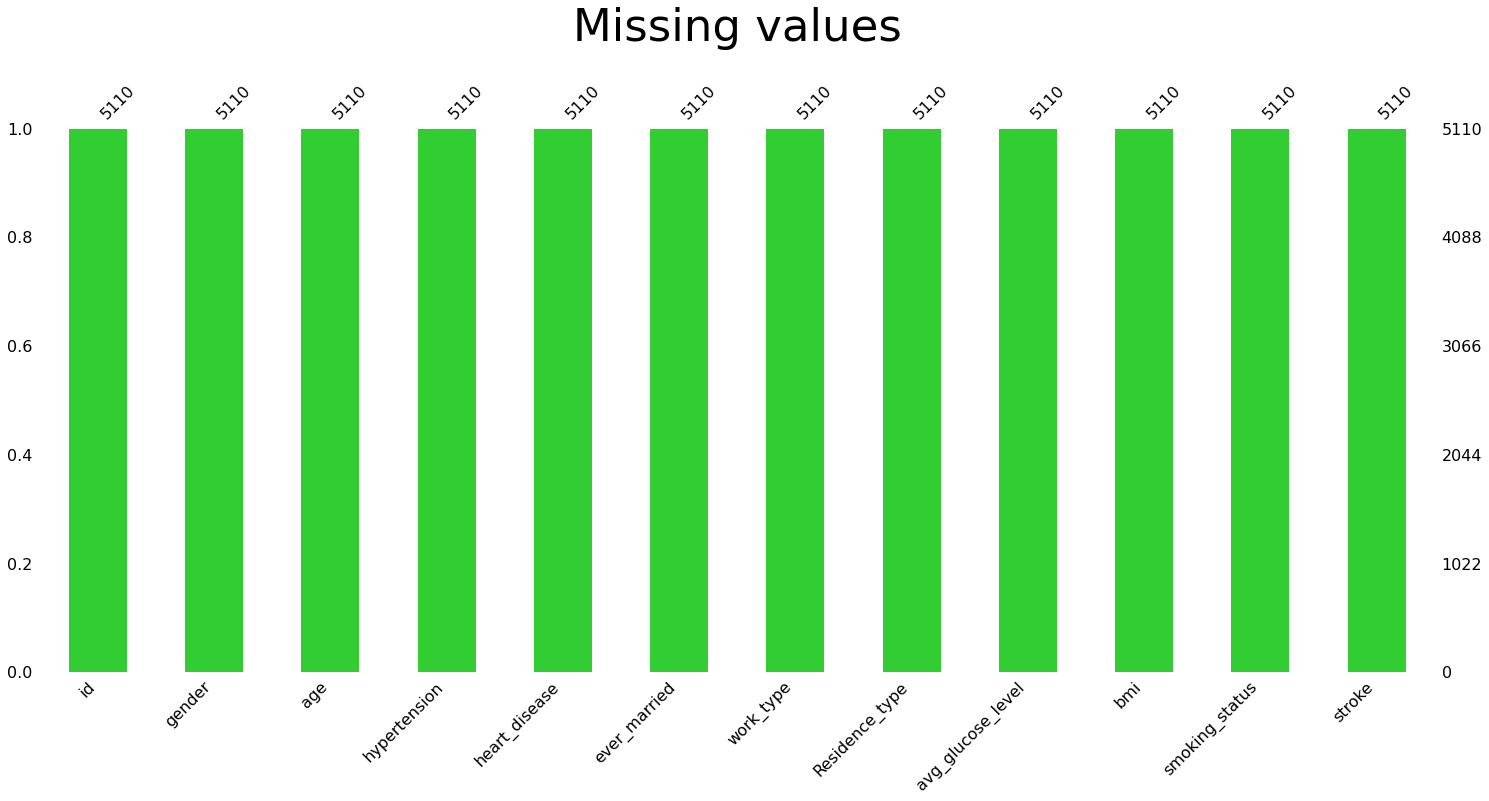

In [19]:
data = pd.read_csv('../Dataset/healthcare-dataset-stroke-data.csv')
data = FillWithMean(data)
data.drop(['id'], axis=1, inplace=True)

In [20]:
data['gender']=data['gender'].apply(lambda x: 1 if x=='Male' else 0)
data['ever_married']=data['ever_married'].apply(lambda x: 1 if x=='Yes' else 0)
data['Residence_type']=data['Residence_type'].apply(lambda x: 1 if x=='Urban' else 0)


def func1(x):
    if x=='Private':
        return 0
    elif x=='Self-employed':
        return 1
    elif x=='Govt-job':
        return 2
    elif x=='children':
        return 3
    else:
        return 4

def func2(x):
    if x=='formerly smoked':
        return 0
    elif x=='never smoked':
        return 1
    elif x=='smokes':
        return 2
    else:
        return 3

data['work_type']=data['work_type'].apply(func1)

data['smoking_status']=data['smoking_status'].apply(func2)

In [21]:
Xorig = data.drop(['stroke'], axis=1)
yorig = data.stroke
sm = SMOTE(random_state=0)
X, y = sm.fit_resample(Xorig, yorig)
print("Total: ", X.shape)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42,stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 42,stratify=y_train)

print("train: ",X_train.shape)
print("val: ",X_val.shape)
print("test: ",X_test.shape)
scaler = joblib.load('./models/WithChi2/scaler_BMI_Chi2.sav')
X_test = scaler.transform(X_test)

Total:  (9722, 10)
train:  (6999, 10)
val:  (778, 10)
test:  (1945, 10)


In [22]:
X_names = Xorig.columns.values
print(X_names)
p_value_limit = 0.98
#this feature selection is ranking features with respect to their usefulness and is not used to make statements about statistical dependence or independence of variables.
features = pd.DataFrame()
for cat in np.unique(y_train):
    chi2test, p = feature_selection.chi2(X_train,y_train==cat)#chi2(tfidf,data["Sentiment"]==cat)
    features = features.append(pd.DataFrame({"feature":X_names,"score":1-p,"Y":cat}))
    features = features.sort_values(["Y","score"],ascending=[True,False])

    features = features[features['score']>p_value_limit]

X_scores = features["score"].unique().tolist()
X_names = features["feature"].unique().tolist()

# praktika h Chi^2 einai
# alpha = 1.0 - prob
# if p <= alpha:
#     print('Dependent (reject H0)')
# else:
#     print('Independent (fail to reject H0)')

for cat in np.unique(data["stroke"]):
    print("# {}:".format(cat))
    print(" . selected features:", len(features[features["Y"]==cat]))
    print(" . top features:",",".join(features[features["Y"]==cat]["feature"].values[:20]))
    # print(" . top features scores:",",".join(str(features[features["Y"]==cat]["score"].values[:10])))
    print(" ")

StatisticalTest = SelectKBest(score_func=chi2, k=5)
fit = StatisticalTest.fit(X_train, y_train)
X_new=StatisticalTest.fit_transform(X_train, y_train)
X_val_new=StatisticalTest.fit_transform(X_val, y_val)
X_test=StatisticalTest.fit_transform(X_test, y_test)

['gender' 'age' 'hypertension' 'heart_disease' 'ever_married' 'work_type'
 'Residence_type' 'avg_glucose_level' 'bmi' 'smoking_status']
# 0:
 . selected features: 8
 . top features: gender,age,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,ever_married
 
# 1:
 . selected features: 8
 . top features: gender,age,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,ever_married
 


In [32]:
from sklearn.metrics import roc_curve
import time
# # calculate roc curves
# fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# # get the best threshold
# J = tpr - fpr
# ix = argmax(J)
# best_thresh = thresholds[ix]
# print('Best Threshold=%f' % (best_thresh))
def getMetrics(clf,name):
    print("For ",name)
    
    predicted_prob2 = clf.predict_proba(X_test)
    start = time.time()
    y_pred2 = clf.predict(X_test)
    duration = time.time()-start
    print("Duration for prediction: ",duration )
    classes = np.unique(y_val)
    y_test_array = pd.get_dummies(y_test, drop_first=False).values
    print(y_test.shape)
    ## Accuracy, Precision, Recall
    accuracy = metrics.accuracy_score(y_test, y_pred2)
    fscore = metrics.f1_score(y_test, y_pred2)

    prec=metrics.precision_score(y_test, y_pred2)
    rec = metrics.recall_score(y_test, y_pred2)
    print("Accuracy:",  round(accuracy,2))
    print("macro F1:",  round(fscore,2))
    print("Recall:", round(rec,2))
    print("Precission:", round(prec,2))
    print("Detail:")
    m_confusion_test = metrics.confusion_matrix(y_test, y_pred2)


    fig, ax = plt.subplots()
    sns.heatmap(m_confusion_test, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues,
                cbar=False)
    ax.set(xlabel="Predicted", ylabel="Actual", xticklabels=classes,
           yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)

    fig, ax = plt.subplots(nrows=1, ncols=2)
    ## Plot roc
    for i in range(len(classes)):
        fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],
                                                 predicted_prob2[:,i])
        ax[0].plot(fpr, tpr, lw=3,
                   label='{0} (area={1:0.2f})'.format(classes[i],
                                                      metrics.auc(fpr, tpr))
                   )
    ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05],
              xlabel='False Positive Rate',
              ylabel="True Positive Rate (Recall)",
              title="Receiver operating characteristic")
    ax[0].legend(loc="lower right")
    ax[0].grid(True)

    optimal_idxGB = np.argmax(tpr - fpr)
    optimal_thresholdGB = thresholds[optimal_idxGB]
    print("Optimal Threshold value is:", optimal_thresholdGB)

    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = metrics.precision_recall_curve(
            y_test_array[:,i], predicted_prob2[:,i])
        ax[1].plot(recall, precision, lw=3,
                   label='{0} (area={1:0.2f})'.format(classes[i],
                                                      metrics.auc(recall, precision))
                   )

    ax[1].plot(thresholds, color='navy', lw=3, linestyle='--')    
    ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall',
              ylabel="Precision", title="Precision-Recall curve")
    ax[1].legend(loc="best")
    ax[1].grid(True)
    plt.show()

In [33]:
filenameLR_BMI_Chi2 = './models/WithChi2/LR_BMI_Chi2.sav'
filenameSVM_BMI_Chi2 = './models/WithChi2/SVM_BMI_Chi2.sav'
filenameRF_BMI_Chi2 = './models/WithChi2/RF_BMI_Chi2.sav'
filenameGB_BMI_Chi2 = './models/WithChi2/GB_BMI_Chi2.sav'
filenameNB_BMI_Chi2 = './models/WithChi2/NB_BMI_Chi2.sav'
GB1 = joblib.load(filenameGB_BMI_Chi2)
RF1 = joblib.load(filenameRF_BMI_Chi2)
LR1 = joblib.load(filenameLR_BMI_Chi2)
SVM1 = joblib.load(filenameSVM_BMI_Chi2)
NB1 = joblib.load(filenameNB_BMI_Chi2)

For  GB
Duration for prediction:  0.022367238998413086
(1945,)
Accuracy: 0.94
macro F1: 0.94
Recall: 0.94
Precission: 0.94
Detail:
Optimal Threshold value is: 0.5348978680545282


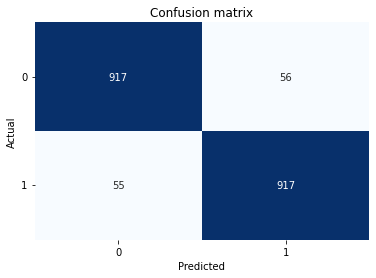

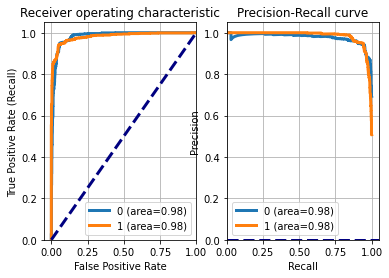

In [34]:
getMetrics(GB1,"GB")

For  RF
Duration for prediction:  0.01800227165222168
(1945,)
Accuracy: 0.88
macro F1: 0.88
Recall: 0.86
Precission: 0.9
Detail:
Optimal Threshold value is: 0.42


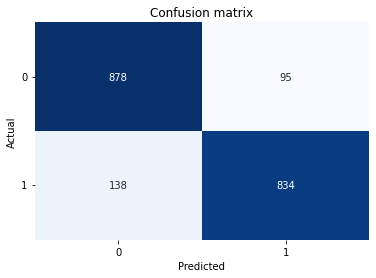

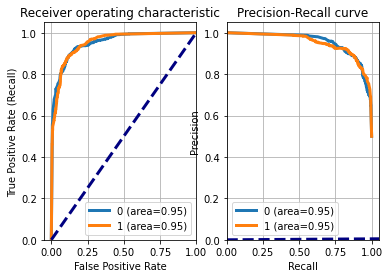

In [35]:
getMetrics(RF1,"RF")

For  SVM
Duration for prediction:  0.40372157096862793
(1945,)
Accuracy: 0.81
macro F1: 0.82
Recall: 0.88
Precission: 0.77
Detail:
Optimal Threshold value is: 0.5445812495455066


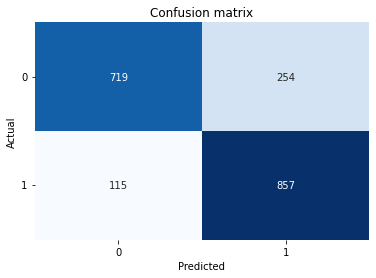

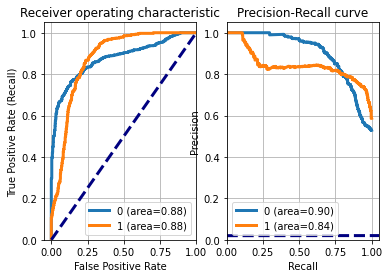

In [36]:
getMetrics(SVM1,"SVM")

For  LR
Duration for prediction:  0.0011534690856933594
(1945,)
Accuracy: 0.78
macro F1: 0.79
Recall: 0.8
Precission: 0.77
Detail:
Optimal Threshold value is: 0.44238342944369785


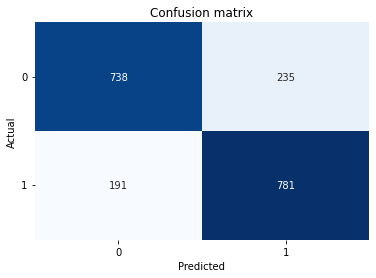

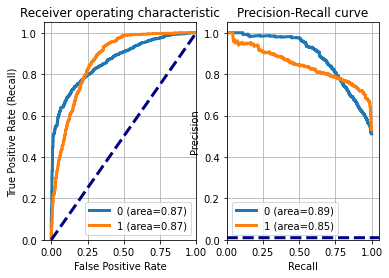

In [37]:
getMetrics(LR1,"LR")

For  NB
Duration for prediction:  0.00023317337036132812
(1945,)
Accuracy: 0.74
macro F1: 0.75
Recall: 0.8
Precission: 0.72
Detail:
Optimal Threshold value is: 0.5077038401505135


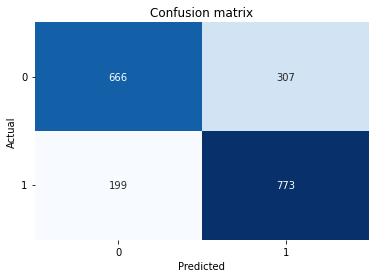

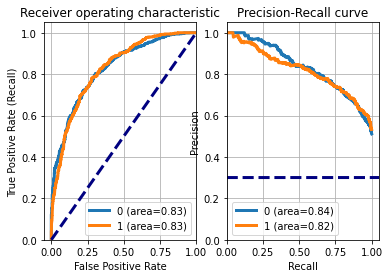

In [38]:
getMetrics(NB1,"NB")

## Metrics without chi2 

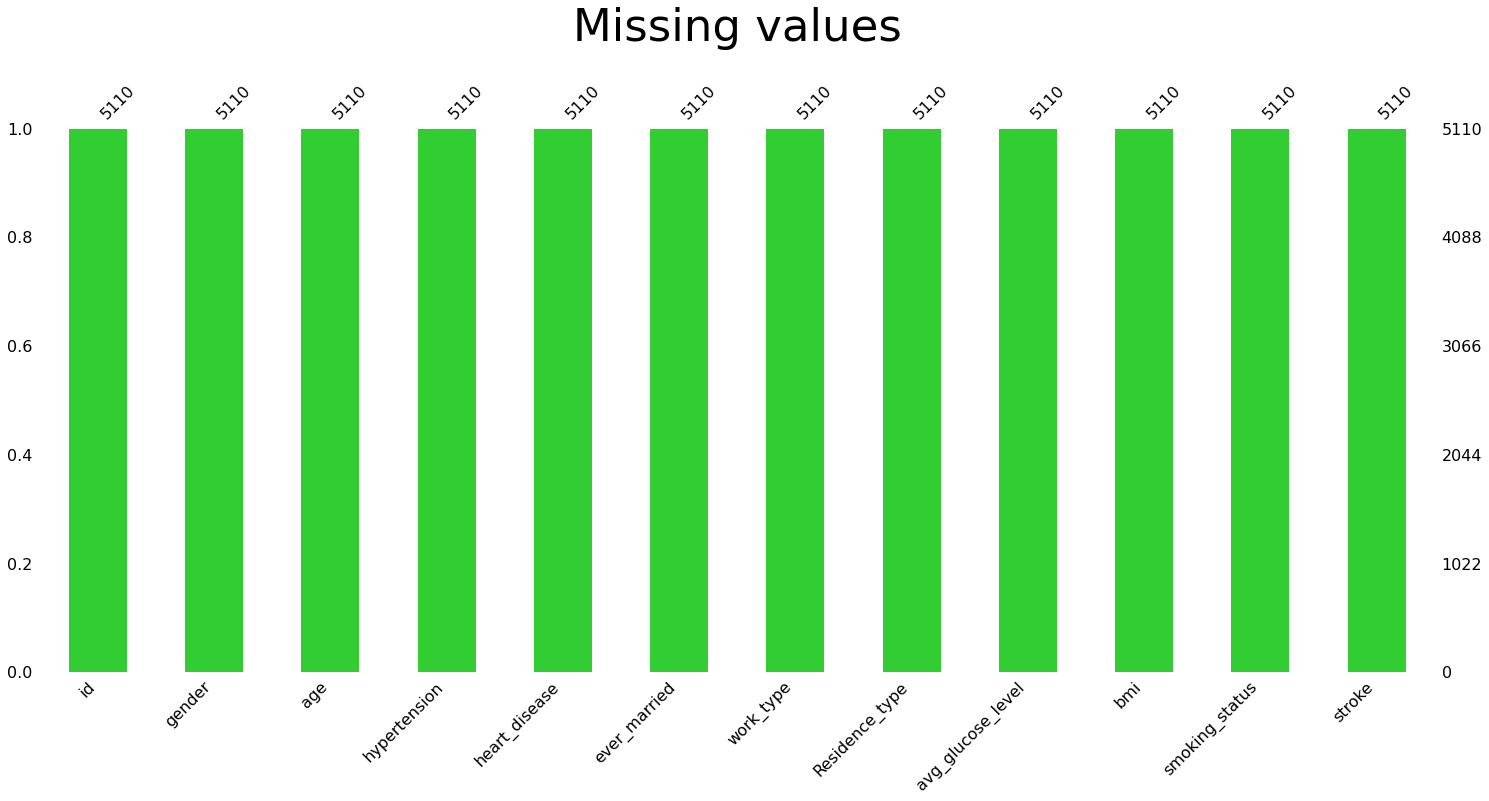

In [39]:
data = pd.read_csv('../Dataset/healthcare-dataset-stroke-data.csv')
data = FillWithMean(data)
data.drop(['id'], axis=1, inplace=True)

In [40]:
data['gender']=data['gender'].apply(lambda x: 1 if x=='Male' else 0)
data['ever_married']=data['ever_married'].apply(lambda x: 1 if x=='Yes' else 0)
data['Residence_type']=data['Residence_type'].apply(lambda x: 1 if x=='Urban' else 0)


def func1(x):
    if x=='Private':
        return 0
    elif x=='Self-employed':
        return 1
    elif x=='Govt-job':
        return 2
    elif x=='children':
        return 3
    else:
        return 4

def func2(x):
    if x=='formerly smoked':
        return 0
    elif x=='never smoked':
        return 1
    elif x=='smokes':
        return 2
    else:
        return 3

data['work_type']=data['work_type'].apply(func1)

data['smoking_status']=data['smoking_status'].apply(func2)

In [41]:
Xorig = data.drop(['stroke'], axis=1)
yorig = data.stroke
sm = SMOTE(random_state=0)
X, y = sm.fit_resample(Xorig, yorig)
print("Total: ", X.shape)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42,stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 42,stratify=y_train)

print("train: ",X_train.shape)
print("val: ",X_val.shape)
print("test: ",X_test.shape)

scaler = joblib.load('./models/WithoutChi2/scaler_BMI_NoChi2.sav')
X_test = scaler.transform(X_test)

Total:  (9722, 10)
train:  (6999, 10)
val:  (778, 10)
test:  (1945, 10)


In [42]:
import joblib
filenameLR_BMI_NoChi2 = './models/WithoutChi2/LR_BMI_NoChi2.sav'
filenameSVM_BMI_NoChi2 = './models/WithoutChi2/SVM_BMI_NoChi2.sav'
filenameRF_BMI_NoChi2 = './models/WithoutChi2/RF_BMI_NoChi2.sav'
filenameGB_BMI_NoChi2 = './models/WithoutChi2/GB_BMI_NoChi2.sav'
filenameNB_BMI_NoChi2 = './models/WithoutChi2/NB_BMI_NoChi2.sav'
GB2 = joblib.load(filenameGB_BMI_NoChi2)
RF2 = joblib.load(filenameRF_BMI_NoChi2)
LR2 = joblib.load(filenameLR_BMI_NoChi2)
SVM2 = joblib.load(filenameSVM_BMI_NoChi2)
NB2 = joblib.load(filenameNB_BMI_NoChi2)

For  GB
Duration for prediction:  0.011368036270141602
(1945,)
Accuracy: 0.97
macro F1: 0.97
Recall: 0.98
Precission: 0.96
Detail:
Optimal Threshold value is: 0.9998329934895377


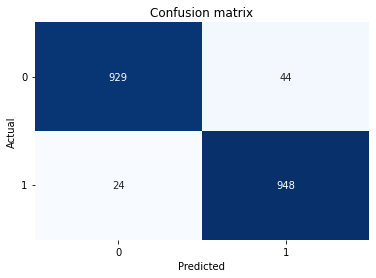

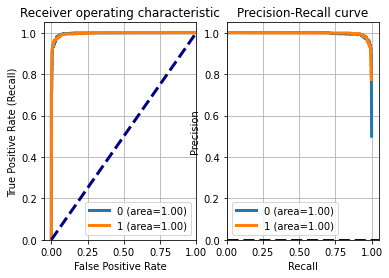

In [43]:
getMetrics(GB2,"GB")

For  RF
Duration for prediction:  0.15469121932983398
(1945,)
Accuracy: 0.94
macro F1: 0.94
Recall: 0.96
Precission: 0.92
Detail:
Optimal Threshold value is: 0.546


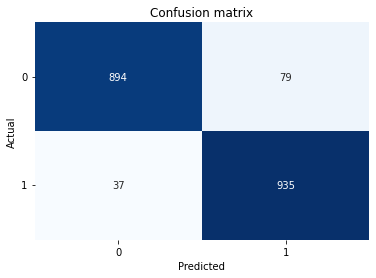

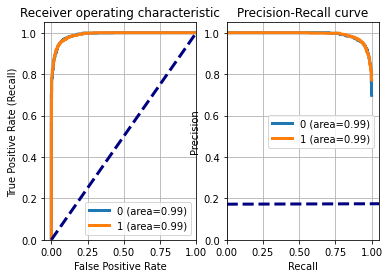

In [44]:
getMetrics(RF2,"RF")

For  SVM
Duration for prediction:  0.3280484676361084
(1945,)
Accuracy: 0.87
macro F1: 0.88
Recall: 0.92
Precission: 0.84
Detail:
Optimal Threshold value is: 0.6746099760121989


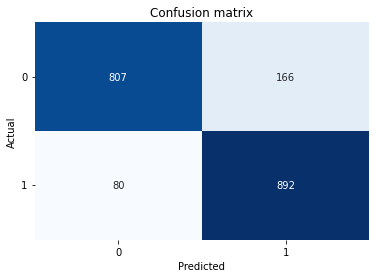

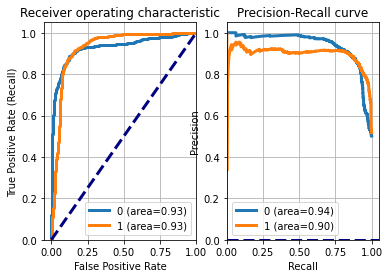

In [45]:
getMetrics(SVM2,"SVM")

For  LR
Duration for prediction:  0.001007080078125
(1945,)
Accuracy: 0.8
macro F1: 0.8
Recall: 0.81
Precission: 0.79
Detail:
Optimal Threshold value is: 0.43368743746299654


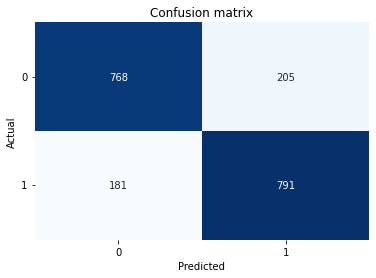

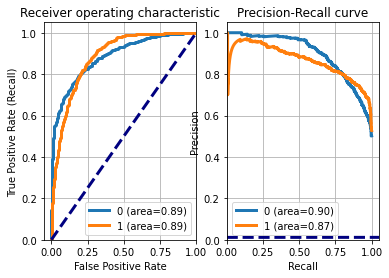

In [46]:
getMetrics(LR2,"LR")

For  NB
Duration for prediction:  0.0012285709381103516
(1945,)
Accuracy: 0.72
macro F1: 0.74
Recall: 0.78
Precission: 0.7
Detail:
Optimal Threshold value is: 0.517091156423256


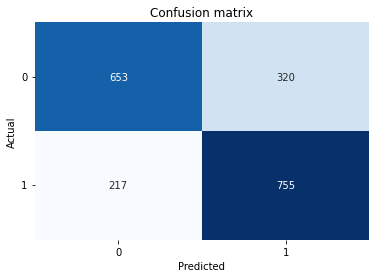

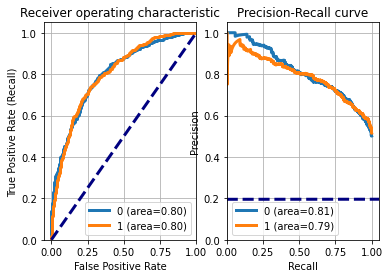

In [47]:
getMetrics(NB2,"NB")

# Fill nan values with Regression

## Metrics with chi2 

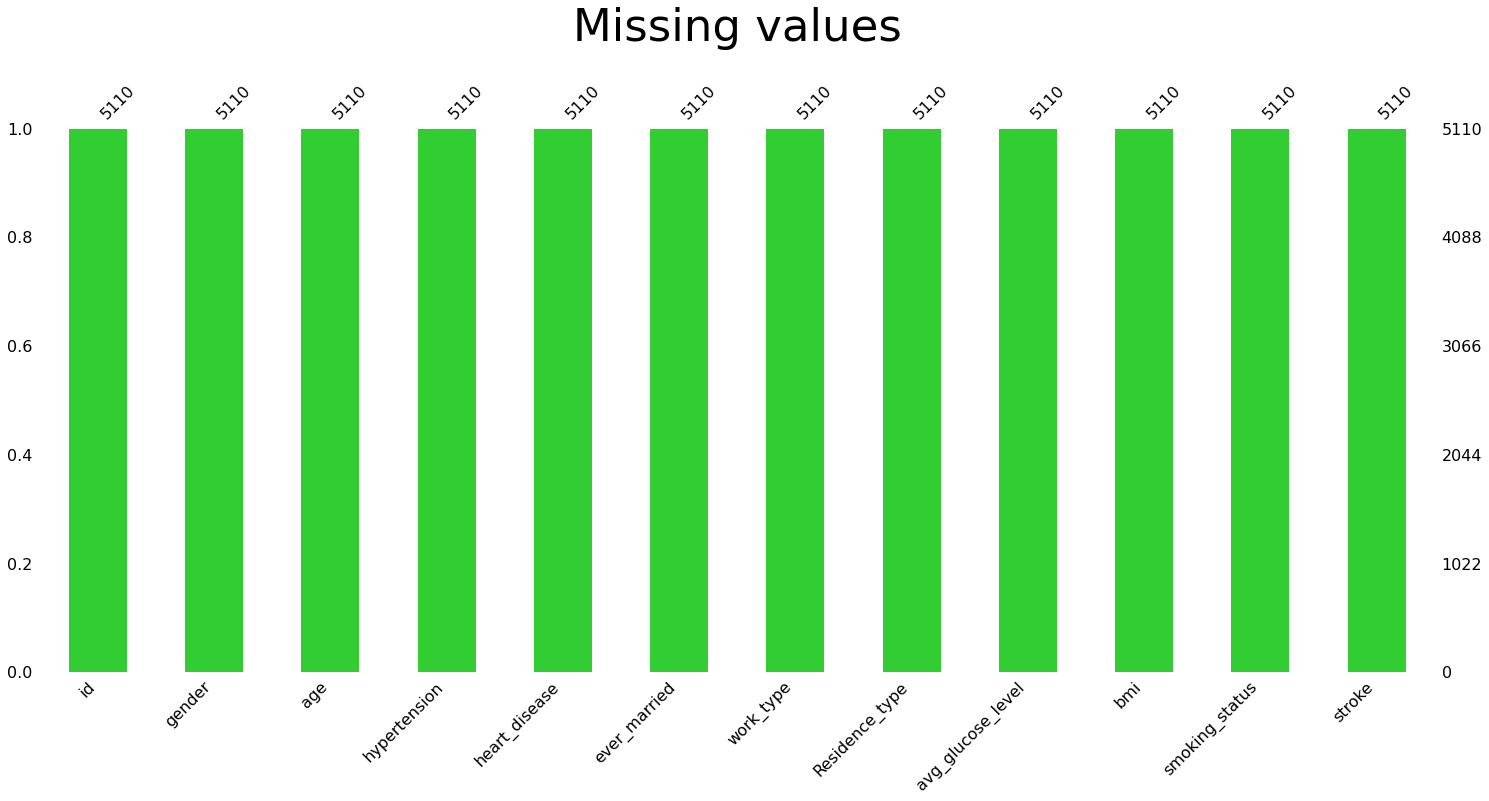

In [48]:
data = pd.read_csv('../Dataset/healthcare-dataset-stroke-data.csv')
data = FillWithLR(data)
data.drop(['id'], axis=1, inplace=True)

In [49]:
data['gender']=data['gender'].apply(lambda x: 1 if x=='Male' else 0)
data['ever_married']=data['ever_married'].apply(lambda x: 1 if x=='Yes' else 0)
data['Residence_type']=data['Residence_type'].apply(lambda x: 1 if x=='Urban' else 0)


def func1(x):
    if x=='Private':
        return 0
    elif x=='Self-employed':
        return 1
    elif x=='Govt-job':
        return 2
    elif x=='children':
        return 3
    else:
        return 4

def func2(x):
    if x=='formerly smoked':
        return 0
    elif x=='never smoked':
        return 1
    elif x=='smokes':
        return 2
    else:
        return 3

data['work_type']=data['work_type'].apply(func1)

data['smoking_status']=data['smoking_status'].apply(func2)

In [50]:
Xorig = data.drop(['stroke'], axis=1)
yorig = data.stroke
sm = SMOTE(random_state=0)
X, y = sm.fit_resample(Xorig, yorig)
print("Total: ", X.shape)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42,stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 42,stratify=y_train)

print("train: ",X_train.shape)
print("val: ",X_val.shape)
print("test: ",X_test.shape)

scaler = joblib.load('./models/WithChi2/scaler_REGR_Chi2.sav')
X_test = scaler.transform(X_test)

Total:  (9722, 10)
train:  (6999, 10)
val:  (778, 10)
test:  (1945, 10)


In [51]:
X_names = Xorig.columns.values
print(X_names)
p_value_limit = 0.98
#this feature selection is ranking features with respect to their usefulness and is not used to make statements about statistical dependence or independence of variables.
features = pd.DataFrame()
for cat in np.unique(y_train):
    chi2test, p = feature_selection.chi2(X_train,y_train==cat)#chi2(tfidf,data["Sentiment"]==cat)
    features = features.append(pd.DataFrame({"feature":X_names,"score":1-p,"Y":cat}))
    features = features.sort_values(["Y","score"],ascending=[True,False])

    features = features[features['score']>p_value_limit]

X_scores = features["score"].unique().tolist()
X_names = features["feature"].unique().tolist()

# praktika h Chi^2 einai
# alpha = 1.0 - prob
# if p <= alpha:
#     print('Dependent (reject H0)')
# else:
#     print('Independent (fail to reject H0)')

for cat in np.unique(data["stroke"]):
    print("# {}:".format(cat))
    print(" . selected features:", len(features[features["Y"]==cat]))
    print(" . top features:",",".join(features[features["Y"]==cat]["feature"].values[:20]))
    # print(" . top features scores:",",".join(str(features[features["Y"]==cat]["score"].values[:10])))
    print(" ")

StatisticalTest = SelectKBest(score_func=chi2, k=5)
fit = StatisticalTest.fit(X_train, y_train)
X_new=StatisticalTest.fit_transform(X_train, y_train)
X_val_new=StatisticalTest.fit_transform(X_val, y_val)
X_test=StatisticalTest.fit_transform(X_test, y_test)

['gender' 'age' 'hypertension' 'heart_disease' 'ever_married' 'work_type'
 'Residence_type' 'avg_glucose_level' 'bmi' 'smoking_status']
# 0:
 . selected features: 8
 . top features: gender,age,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,ever_married
 
# 1:
 . selected features: 8
 . top features: gender,age,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,ever_married
 


In [52]:
filenameLR_REGR_Chi2 = './models/WithChi2/LR_REGR_Chi2.sav'
filenameSVM_REGR_Chi2 = './models/WithChi2/SVM_REGR_Chi2.sav'
filenameRF_REGR_Chi2 = './models/WithChi2/RF_REGR_Chi2.sav'
filenameGB_REGR_Chi2 = './models/WithChi2/GB_REGR_Chi2.sav'
filenameNB_REGR_Chi2 = './models/WithChi2/NB_REGR_Chi2.sav'
GB_reg1 = joblib.load(filenameGB_REGR_Chi2)
RF_reg1 = joblib.load(filenameRF_REGR_Chi2)
LR_reg1 = joblib.load(filenameLR_REGR_Chi2)
SVM_reg1 = joblib.load(filenameSVM_REGR_Chi2)
NB_reg1 = joblib.load(filenameNB_REGR_Chi2)

For  GB
Duration for prediction:  0.017075300216674805
(1945,)
Accuracy: 0.94
macro F1: 0.94
Recall: 0.94
Precission: 0.94
Detail:
Optimal Threshold value is: 0.5051248241488054


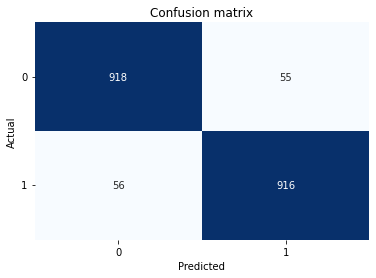

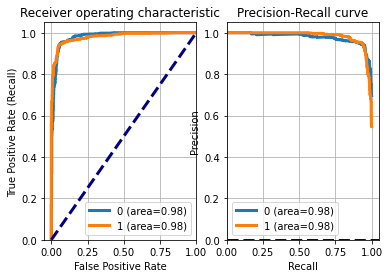

In [53]:
getMetrics(GB_reg1,"GB")

For  RF
Duration for prediction:  0.034781694412231445
(1945,)
Accuracy: 0.88
macro F1: 0.87
Recall: 0.84
Precission: 0.9
Detail:
Optimal Threshold value is: 0.41


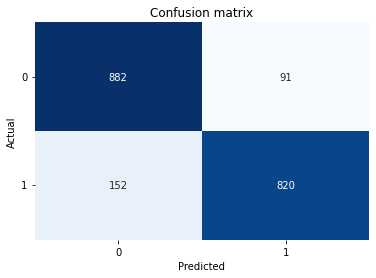

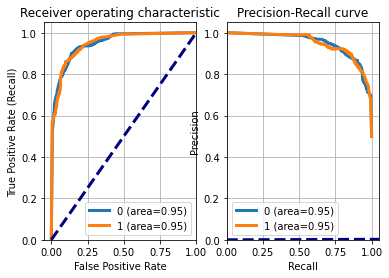

In [54]:
getMetrics(RF_reg1,"RF")

For  SVM
Duration for prediction:  0.39641356468200684
(1945,)
Accuracy: 0.81
macro F1: 0.82
Recall: 0.88
Precission: 0.77
Detail:
Optimal Threshold value is: 0.5113437314329327


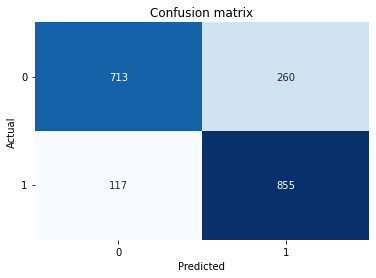

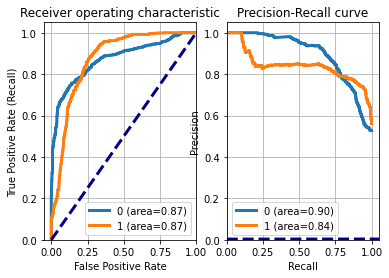

In [55]:
getMetrics(SVM_reg1,"SVM")

For  NB
Duration for prediction:  0.0
(1945,)
Accuracy: 0.75
macro F1: 0.76
Recall: 0.81
Precission: 0.72
Detail:
Optimal Threshold value is: 0.49847860237999


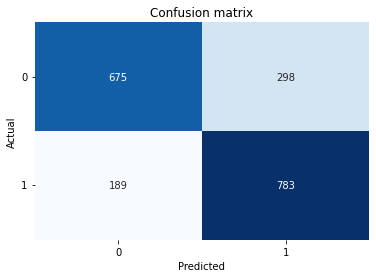

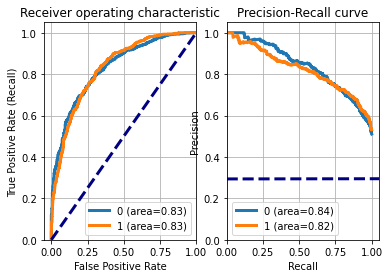

In [56]:
getMetrics(NB_reg1,"NB")

For  LR
Duration for prediction:  0.0010039806365966797
(1945,)
Accuracy: 0.79
macro F1: 0.79
Recall: 0.81
Precission: 0.77
Detail:
Optimal Threshold value is: 0.4692211982635468


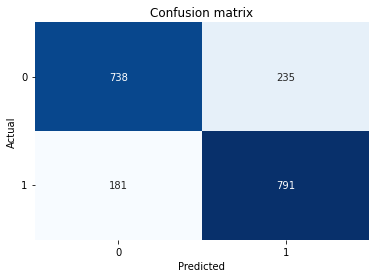

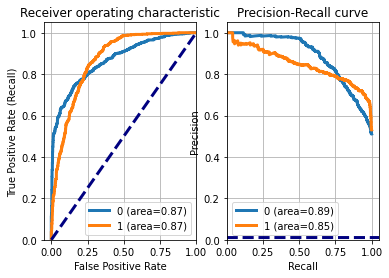

In [57]:
getMetrics(LR_reg1,"LR")

## Metrics  without chi2 

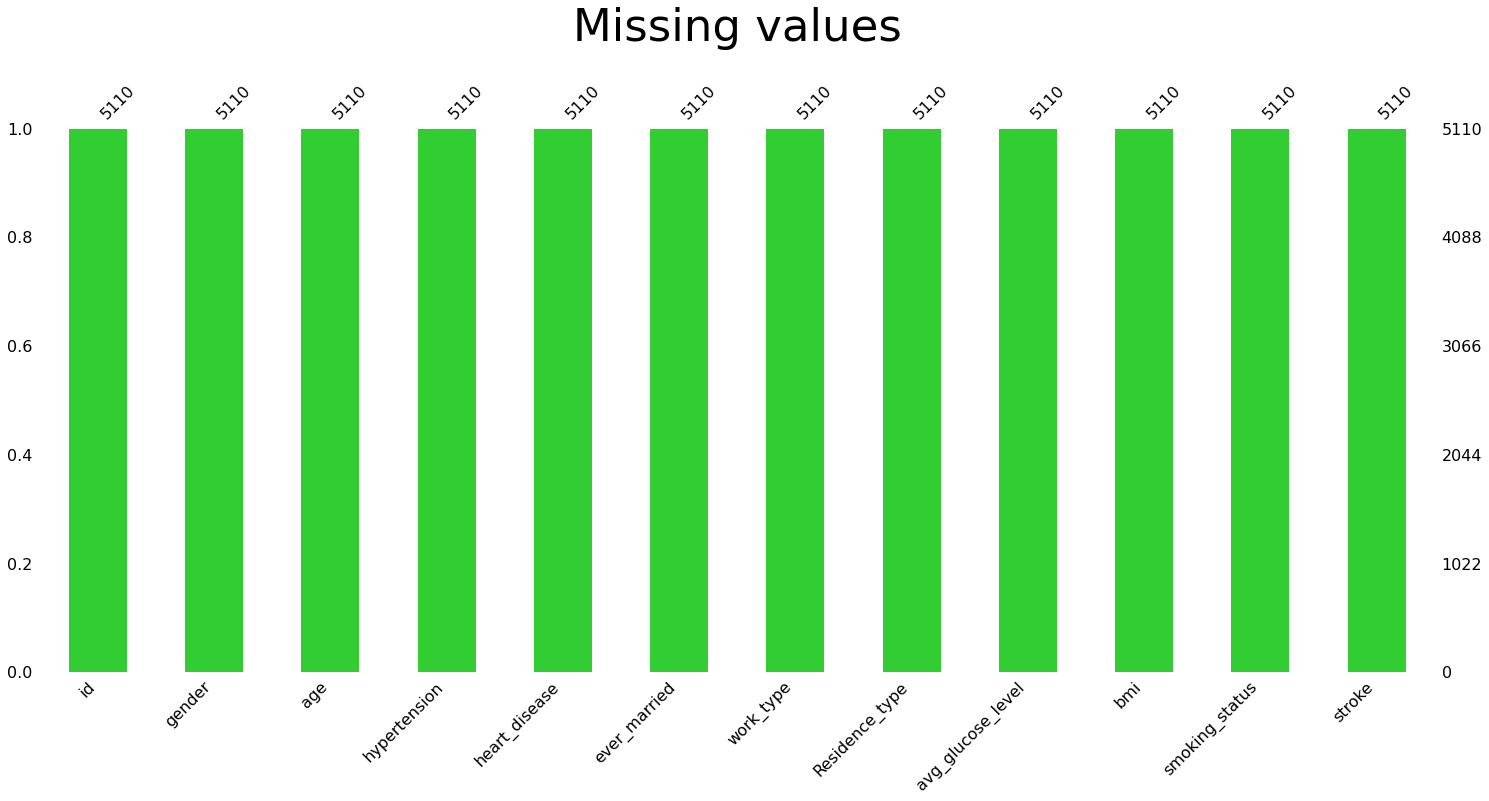

In [58]:
data = pd.read_csv('../Dataset/healthcare-dataset-stroke-data.csv')
data = FillWithLR(data)
data.drop(['id'], axis=1, inplace=True)

In [59]:
data['gender']=data['gender'].apply(lambda x: 1 if x=='Male' else 0)
data['ever_married']=data['ever_married'].apply(lambda x: 1 if x=='Yes' else 0)
data['Residence_type']=data['Residence_type'].apply(lambda x: 1 if x=='Urban' else 0)


def func1(x):
    if x=='Private':
        return 0
    elif x=='Self-employed':
        return 1
    elif x=='Govt-job':
        return 2
    elif x=='children':
        return 3
    else:
        return 4

def func2(x):
    if x=='formerly smoked':
        return 0
    elif x=='never smoked':
        return 1
    elif x=='smokes':
        return 2
    else:
        return 3

data['work_type']=data['work_type'].apply(func1)

data['smoking_status']=data['smoking_status'].apply(func2)

In [61]:
Xorig = data.drop(['stroke'], axis=1)
yorig = data.stroke
sm = SMOTE(random_state=0)
X, y = sm.fit_resample(Xorig, yorig)
print("Total: ", X.shape)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42,stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 42,stratify=y_train)

print("train: ",X_train.shape)
print("val: ",X_val.shape)
print("test: ",X_test.shape)
scaler = joblib.load('./models/WithoutChi2/scaler_RERG_NoChi2.sav')
X_test = scaler.transform(X_test)

Total:  (9722, 10)
train:  (6999, 10)
val:  (778, 10)
test:  (1945, 10)


In [62]:
filenameLR_RERG_NoChi2 = './models/WithoutChi2/LR_RERG_NoChi2.sav'
filenameSVM_RERG_NoChi2 = './models/WithoutChi2/SVM_RERG_NoChi2.sav'
filenameRF_RERG_NoChi2 = './models/WithoutChi2/RF_RERG_NoChi2.sav'
filenameGB_RERG_NoChi2 = './models/WithoutChi2/GB_RERG_NoChi2.sav'
filenameNB_RERG_NoChi2 = './models/WithoutChi2/NB_RERG_NoChi2.sav'
GB_reg2 = joblib.load(filenameGB_RERG_NoChi2)
RF_reg2 = joblib.load(filenameRF_RERG_NoChi2)
LR_reg2 = joblib.load(filenameLR_RERG_NoChi2)
SVM_reg2 = joblib.load(filenameSVM_RERG_NoChi2)
NB_reg2 = joblib.load(filenameNB_RERG_NoChi2)

For  GB
Duration for prediction:  0.043999671936035156
(1945,)
Accuracy: 0.97
macro F1: 0.97
Recall: 0.97
Precission: 0.97
Detail:
Optimal Threshold value is: 0.9307101788816952


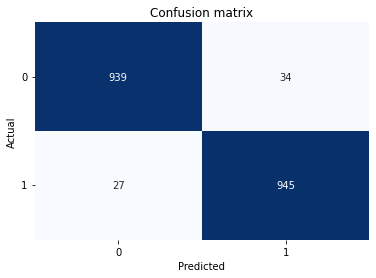

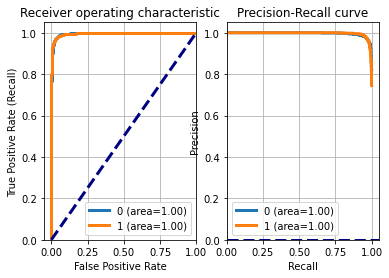

In [63]:
getMetrics(GB_reg2,"GB")

For  RF
Duration for prediction:  0.09506368637084961
(1945,)
Accuracy: 0.94
macro F1: 0.94
Recall: 0.96
Precission: 0.92
Detail:
Optimal Threshold value is: 0.59


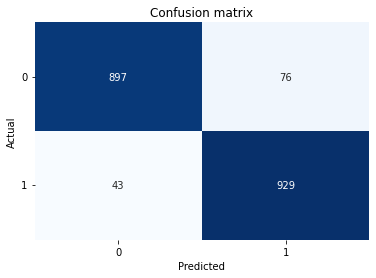

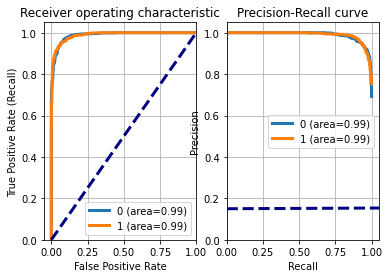

In [64]:
getMetrics(RF_reg2,"RF")

For  SVM
Duration for prediction:  0.3256838321685791
(1945,)
Accuracy: 0.87
macro F1: 0.87
Recall: 0.91
Precission: 0.84
Detail:
Optimal Threshold value is: 0.6406548304928753


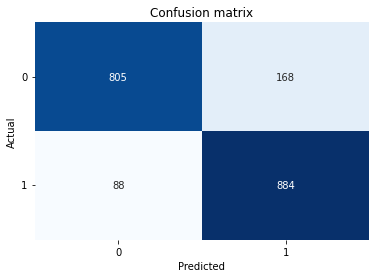

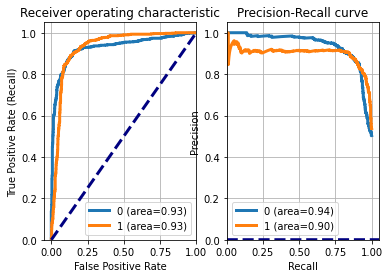

In [65]:
getMetrics(SVM_reg2,"SVM")

For  NB
Duration for prediction:  0.0
(1945,)
Accuracy: 0.73
macro F1: 0.74
Recall: 0.78
Precission: 0.7
Detail:
Optimal Threshold value is: 0.5364056833741092


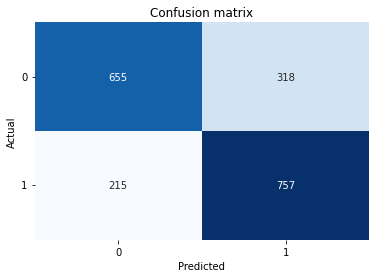

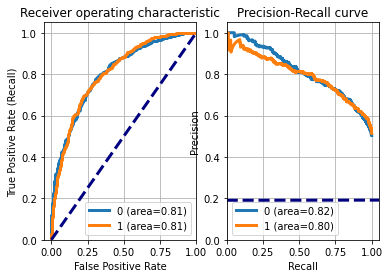

In [66]:
getMetrics(NB_reg2,"NB")

For  LR
Duration for prediction:  0.005128622055053711
(1945,)
Accuracy: 0.8
macro F1: 0.81
Recall: 0.83
Precission: 0.79
Detail:
Optimal Threshold value is: 0.4717175297453123


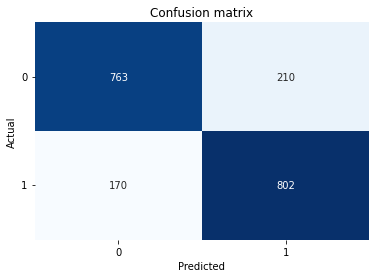

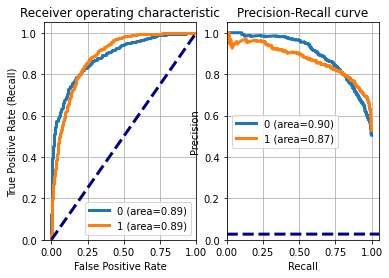

In [67]:
getMetrics(LR_reg2,"LR")